<a href="https://colab.research.google.com/github/Mitmischer/sepsis-prediction/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sepsis Prediction
Early prediction of sepsis from clinical data, using the [PhysioNet/Computing in Cardiology Challenge 2019 Dataset](https://physionet.org/content/challenge-2019/1.0.0/)

## Setup

In [1]:
from google.colab import drive
import tarfile
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%pip install zstandard
import zstandard
drive.mount('/content/drive')
%mkdir -p "/tmp/sepsis"
%cp "/content/drive/My Drive/sepsis/training.tar.zst" "/tmp/sepsis"
%cp /content/drive/My\ Drive/sepsis/training_setA*.csv "/tmp/sepsis"
%cd "/tmp/sepsis"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 30.9 MB/s eta 0:00:00
Mounted at /content/drive
/tmp/sepsis


**Read data file**

In [3]:
# EITHER: run this line
# OR: run all cells until "Optional: save as csv"
full_df = pd.read_csv("/tmp/sepsis/training_setA.csv")

In [4]:
dctx = zstandard.ZstdDecompressor()
with open("training.tar.zst", 'rb') as ifh, open("training.tar", 'wb') as ofh:
    dctx.copy_stream(ifh, ofh)

my_tar = tarfile.open('training.tar')
my_tar.extractall('/tmp/sepsis') # specify which folder to extract to
my_tar.close()
%cd "training/training_setA"

/tmp/sepsis/training/training_setA


In [5]:
# load all data sets (roughly 20000 for set A)
wd = Path(".")
full_df_from_disk = list(pd.read_csv(f, sep = "|") for f in wd.glob("p0*.psv"))
full_df = pd.concat(full_df_from_disk)

## Preprocess Data File
Only if data was read in via .psv files

In [6]:
full_df.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,69.0,95.0,35.72,98.0,75.0,54.0,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,80.58,1,NaN,NaN,-0.02,2,0
1,67.0,95.5,NaN,94.0,79.0,65.0,16.0,NaN,NaN,NaN,...,NaN,NaN,NaN,80.58,1,NaN,NaN,-0.02,3,0
2,63.0,97.5,NaN,78.5,67.0,53.0,15.0,NaN,NaN,NaN,...,NaN,NaN,NaN,80.58,1,NaN,NaN,-0.02,4,0
3,60.0,99.0,NaN,88.0,73.0,58.0,17.0,NaN,NaN,NaN,...,NaN,NaN,NaN,80.58,1,NaN,NaN,-0.02,5,0
4,58.0,96.0,36.50,83.0,69.0,56.0,16.0,NaN,NaN,25.0,...,30.7,NaN,119.0,80.58,1,NaN,NaN,-0.02,6,0


In [7]:
full_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

Reset index, creating time variable

In [8]:
def add_patient_id_and_idx(df):
  # Reset index, creating time variable
  df = df.reset_index(names=["time"])
  # Add patient id variable
  groups_by_patient = df['time'].diff().lt(0)
  groups_by_sepsis_label = df['SepsisLabel'].diff().abs().gt(0)
  result = pd.concat([groups_by_patient, groups_by_sepsis_label], axis=1)
  groups = result.any(axis=1)
  df['patient_id'] = groups_by_patient.cumsum()
  df['measurement_id'] = groups.cumsum()

  return df

In [10]:
full_df = add_patient_id_and_idx(full_df)

In [9]:
display(full_df)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,69.0,95.0,35.72,98.0,75.00,54.0,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,80.58,1,NaN,NaN,-0.02,2,0
1,67.0,95.5,NaN,94.0,79.00,65.0,16.0,NaN,NaN,NaN,...,NaN,NaN,NaN,80.58,1,NaN,NaN,-0.02,3,0
2,63.0,97.5,NaN,78.5,67.00,53.0,15.0,NaN,NaN,NaN,...,NaN,NaN,NaN,80.58,1,NaN,NaN,-0.02,4,0
3,60.0,99.0,NaN,88.0,73.00,58.0,17.0,NaN,NaN,NaN,...,NaN,NaN,NaN,80.58,1,NaN,NaN,-0.02,5,0
4,58.0,96.0,36.50,83.0,69.00,56.0,16.0,NaN,NaN,25.0,...,30.7,NaN,119.0,80.58,1,NaN,NaN,-0.02,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,96.0,99.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,72.53,1,NaN,NaN,-26.63,37,0
37,94.5,99.5,36.56,90.0,63.33,NaN,22.0,NaN,6.0,28.0,...,10.0,NaN,129.0,72.53,1,NaN,NaN,-26.63,38,0
38,100.0,100.0,NaN,98.0,66.17,NaN,22.5,NaN,NaN,NaN,...,NaN,NaN,NaN,72.53,1,NaN,NaN,-26.63,39,0
39,98.0,100.0,NaN,91.0,63.67,NaN,29.0,NaN,NaN,NaN,...,NaN,NaN,NaN,72.53,1,NaN,NaN,-26.63,40,0


Optional: save as csv

In [11]:
full_df.to_csv("/tmp/sepsis/training_setA.csv", index=False)

## Exploratory Data Analysis

### Single and Subsample Analysis

Single case

In [12]:
first_patient_df = pd.read_csv("p000010.psv", sep="|")

<Axes: >

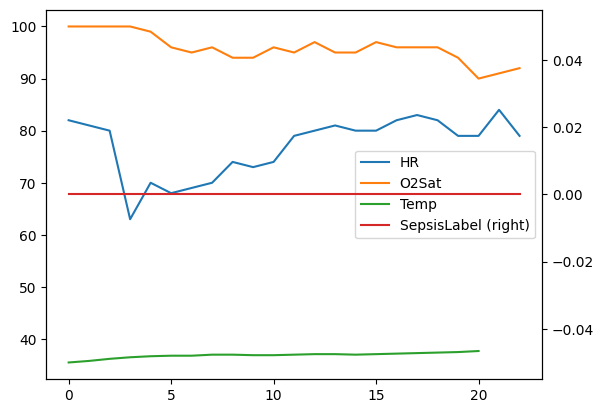

In [13]:
ax = first_patient_df[["HR", "O2Sat", "Temp"]].plot()
first_patient_df[["SepsisLabel"]].plot(secondary_y=True, ax=ax)

In [14]:
first_patient_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

<Axes: >

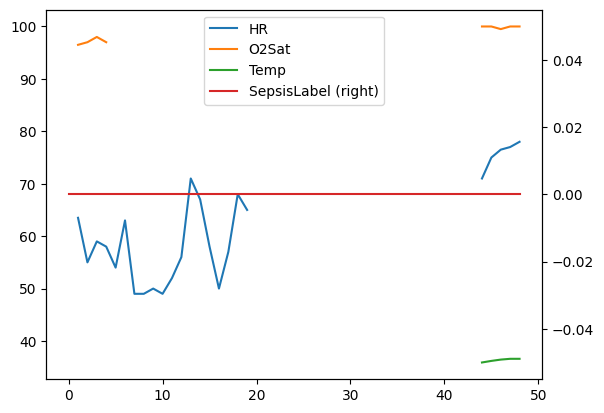

In [15]:
second_patient_df = pd.read_csv("p000111.psv", sep="|")
ax = second_patient_df[["HR", "O2Sat", "Temp"]].plot()
second_patient_df[["SepsisLabel"]].plot(secondary_y=True, ax=ax)

Subsample (first n samples)

In [16]:
# load the first 10 data sets
wd = Path(".")
sample_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p00000*.psv"))
sample_df = pd.concat(sample_df)

<Axes: >

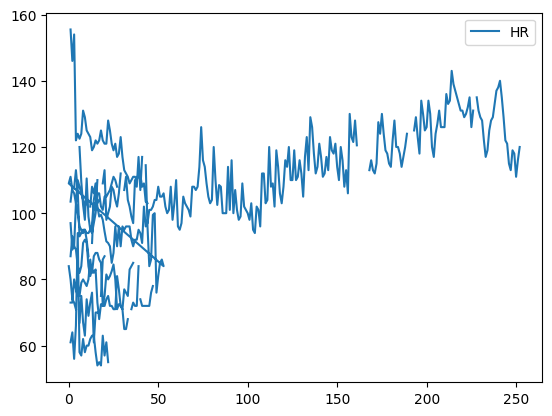

In [17]:
sample_df[["HR"]].plot()

39.6956956956957 mean total hours time in the ICU


Text(0.5, 0, 'ICULOS (days)')

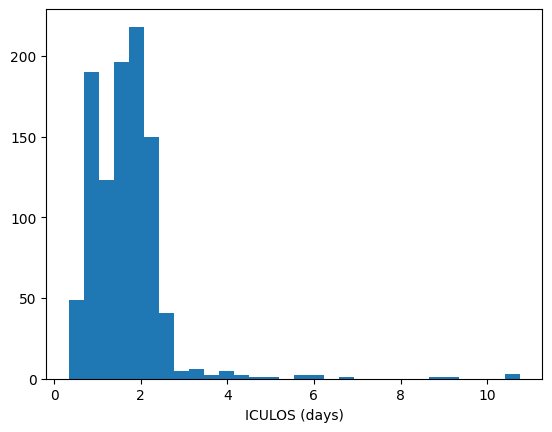

In [18]:
# load the first 1000 data sets
# what is the mean total time in the ICU (ICULOS)?
# ICULOS = intensive care unit length of stay
wd = Path(".")
big_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p000*.psv"))
ICULOS_times = np.array([])
for df in big_df:
  ICULOS_times = np.append(ICULOS_times, df[["ICULOS"]].max())
print(f"{np.mean(ICULOS_times)} mean total hours time in the ICU")
plt.hist(ICULOS_times/24, bins=30)
plt.xlabel('ICULOS (days)')

### Full Sample Analysis

Number of patiens in total and patients with sepsis

In [19]:
print("Number of patients:", len(full_df['patient_id'].unique()))

grp_sepsis_rep = np.array(full_df.groupby(['patient_id']) \
                          ['SepsisLabel'].sum())

print("Number of patients with sepsis:", len(grp_sepsis_rep[grp_sepsis_rep > 0]))


print("Percentage of positive cases:", round(len(grp_sepsis_rep[grp_sepsis_rep > 0])/len(full_df['patient_id'].unique())*100, 2), "%")



Number of patients: 20336
Number of patients with sepsis: 1790
Percentage of positive cases: 8.8 %


Number of hours a patient spent in hospital

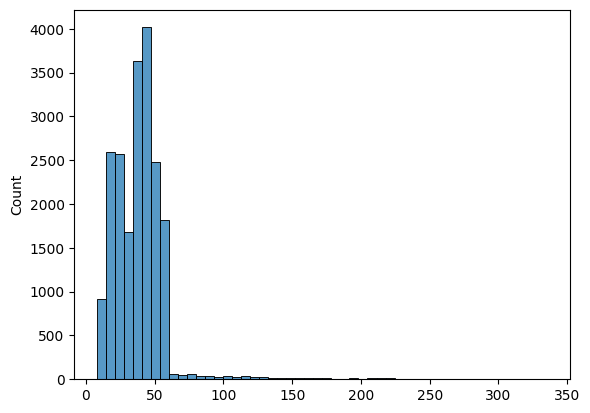

In [20]:
agg_patient_time = np.array(full_df.groupby(['patient_id'])['SepsisLabel']\
                            .count())

sns.histplot(agg_patient_time, kde=False, bins = 50);

Time at which a patient contracts Sepsis

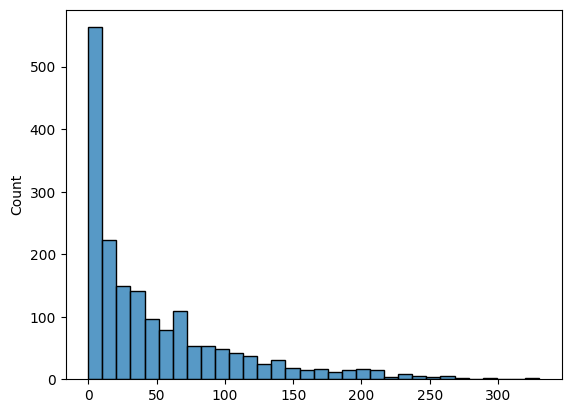

In [21]:

temp = full_df.groupby(['patient_id'])['SepsisLabel']\
       .sum().reset_index()

sepsis_pid = np.array(temp[temp['SepsisLabel'] > 0]['patient_id'])


temp_filter = full_df[full_df['patient_id']\
                                   .isin(sepsis_pid)]

sepsis_time = []
tot_time = []


for pid in sepsis_pid:
  df = temp_filter[temp_filter['patient_id']==pid]
  sepsis_time.append(df[df['SepsisLabel']==1]['time'].iloc[0])
  tot_time.append(df[df['SepsisLabel']==1]['time'][::-1].iloc[0])

sns.histplot(sepsis_time, kde=False);


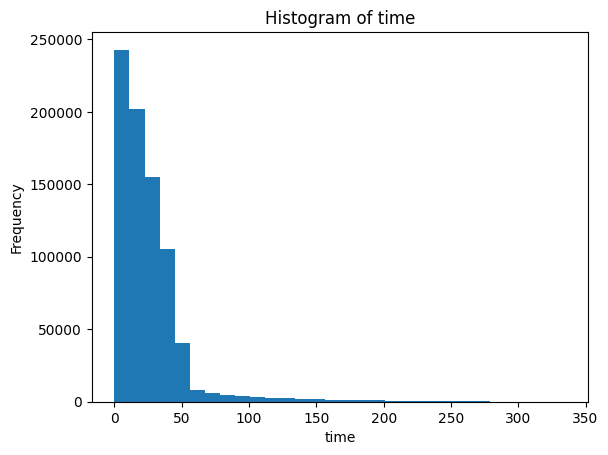

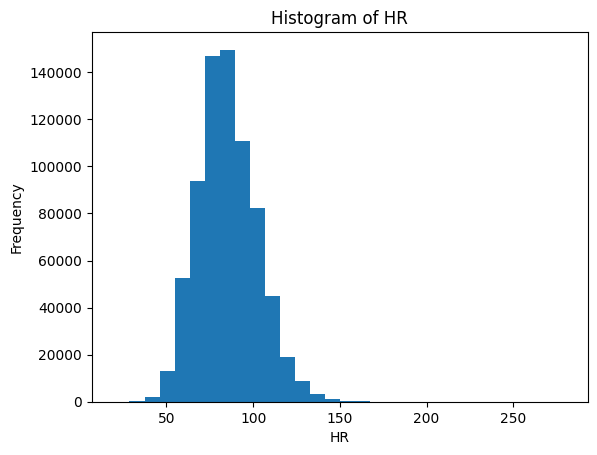

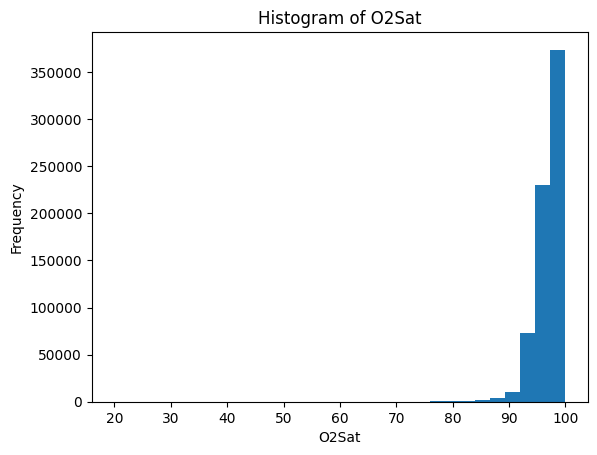

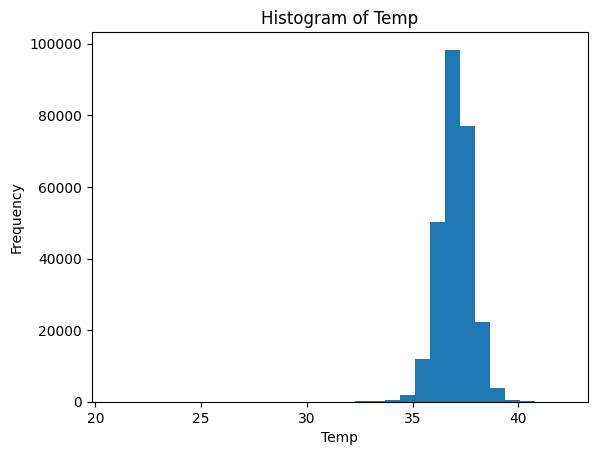

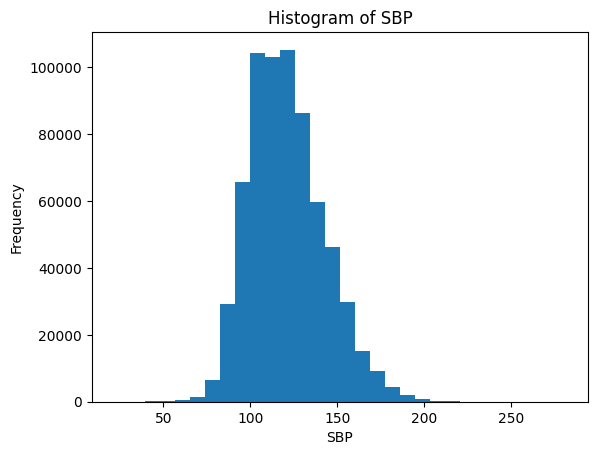

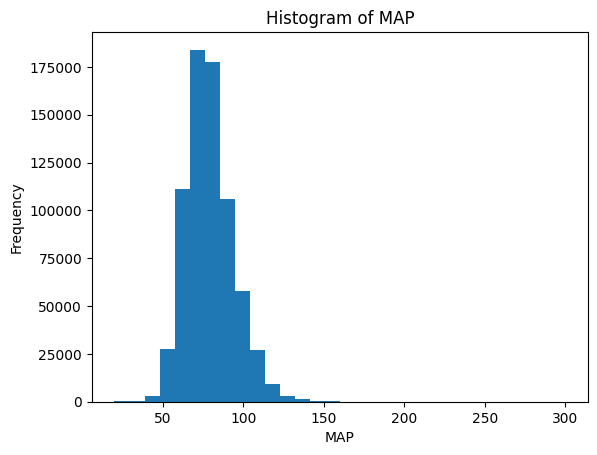

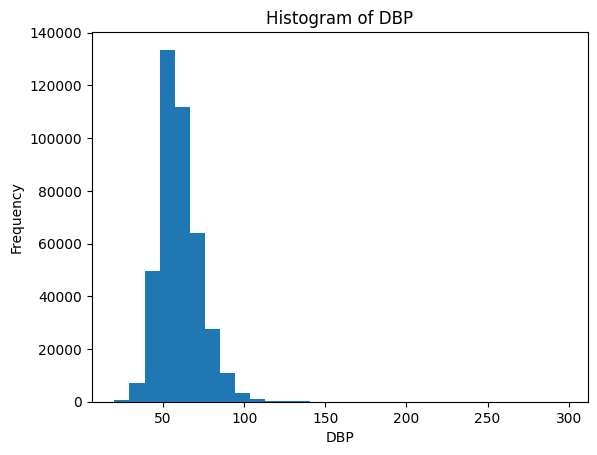

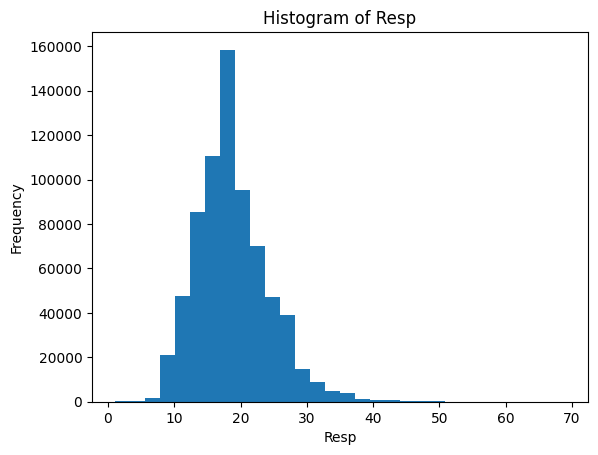

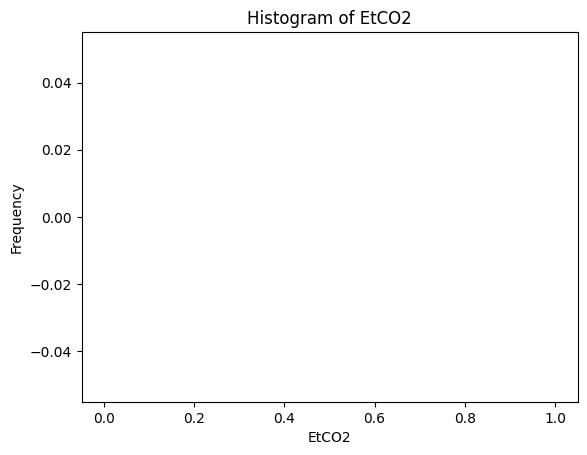

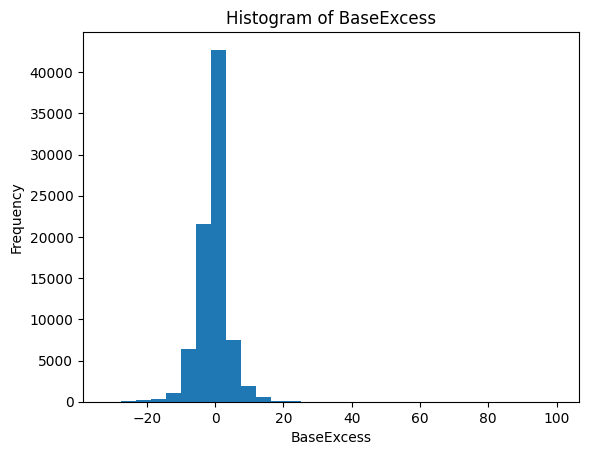

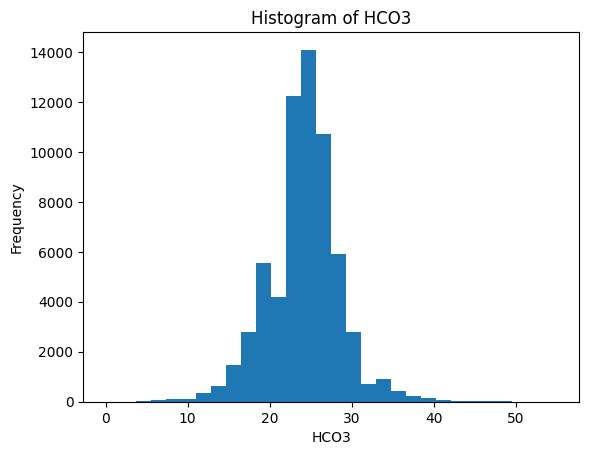

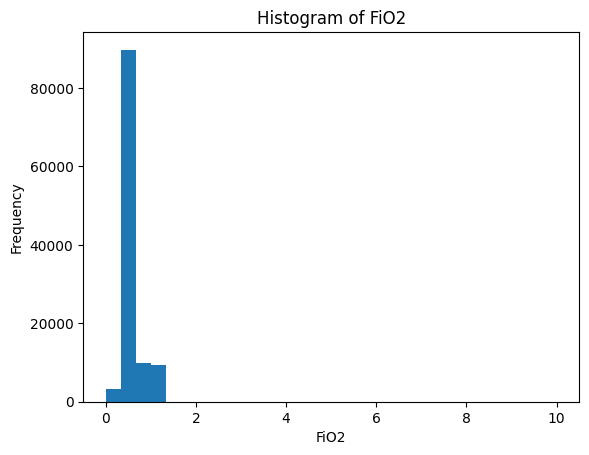

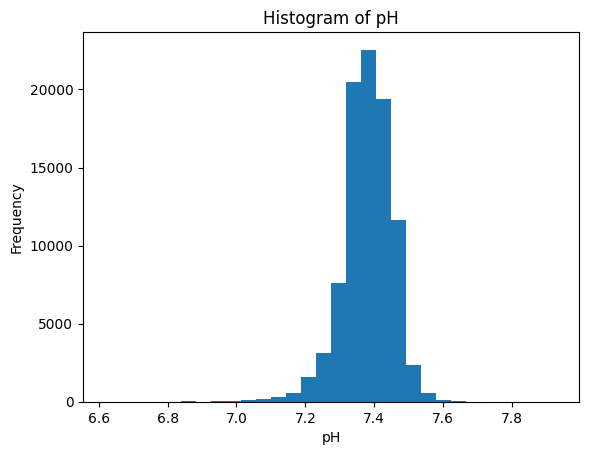

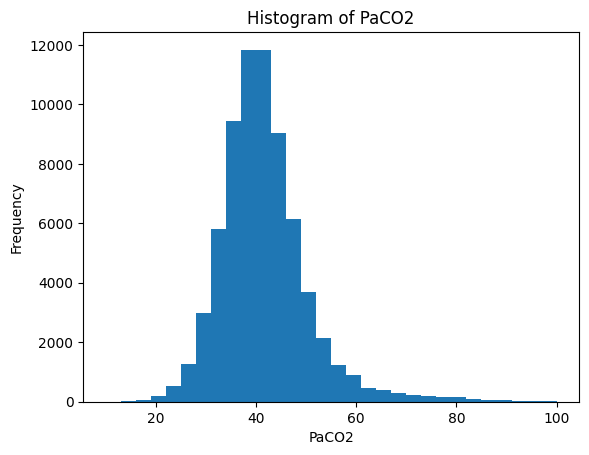

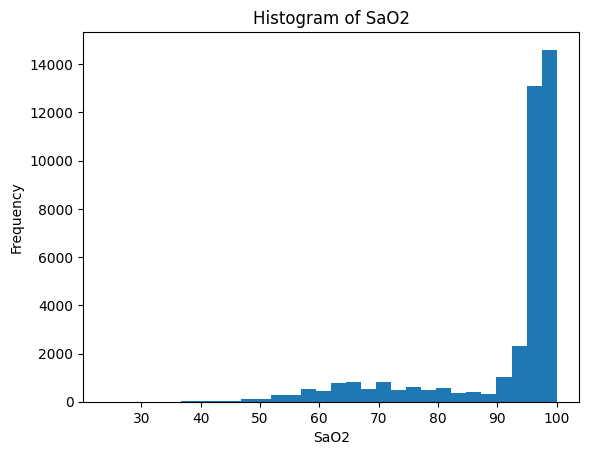

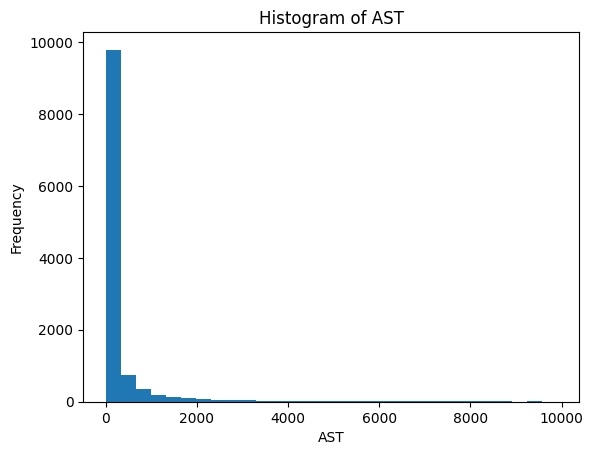

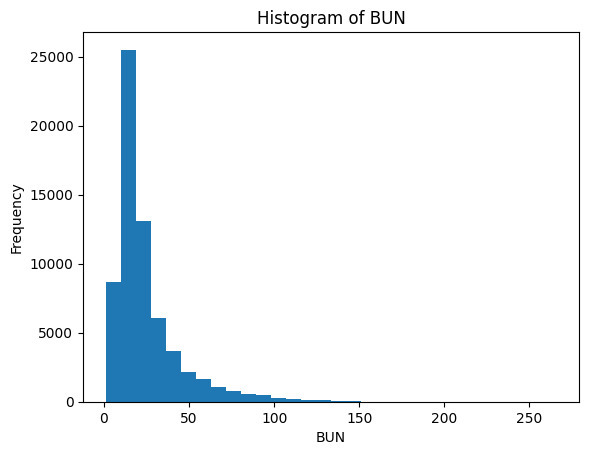

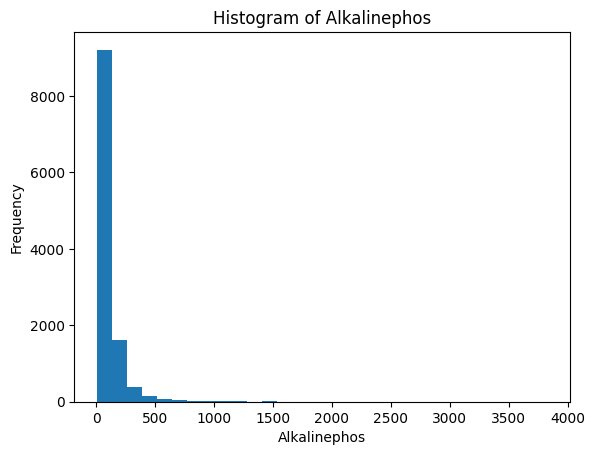

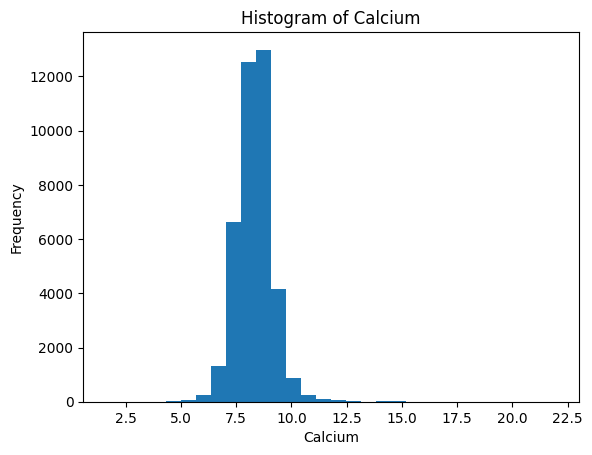

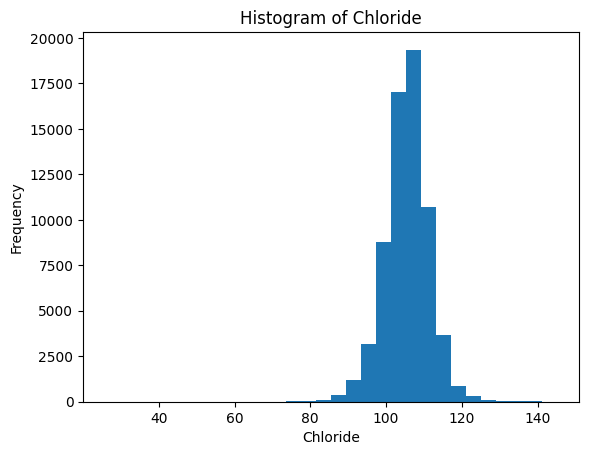

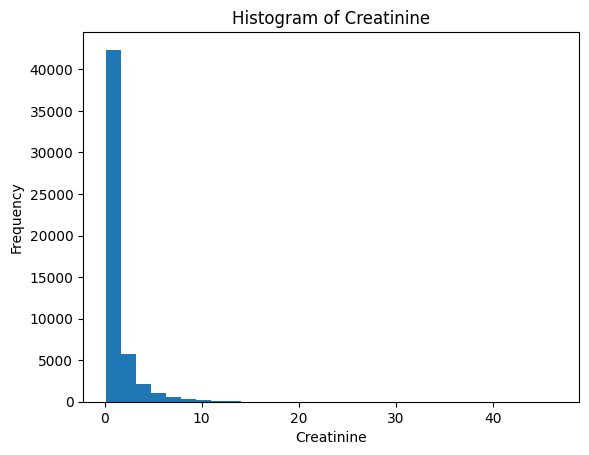

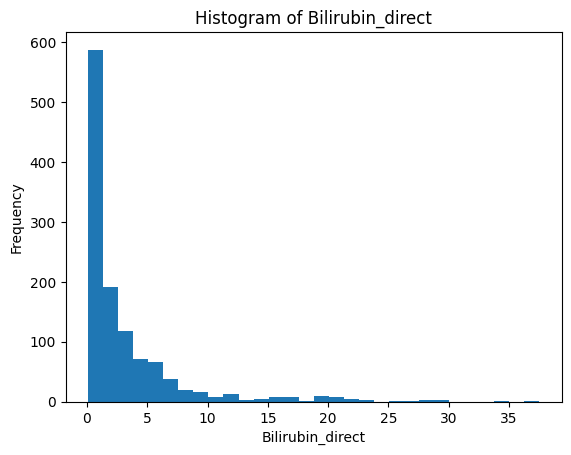

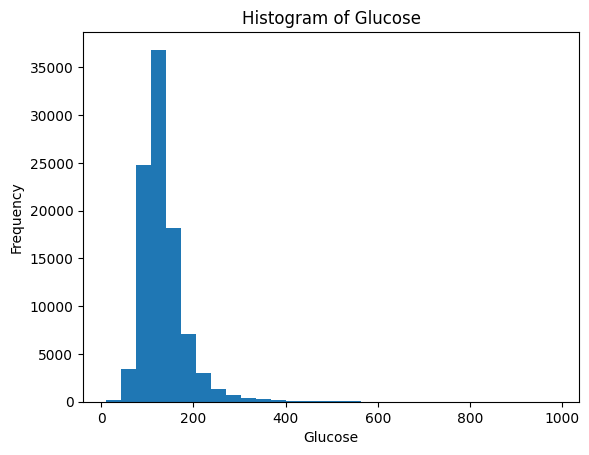

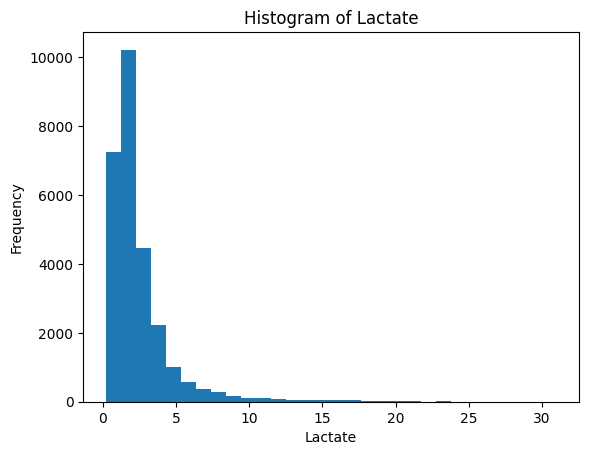

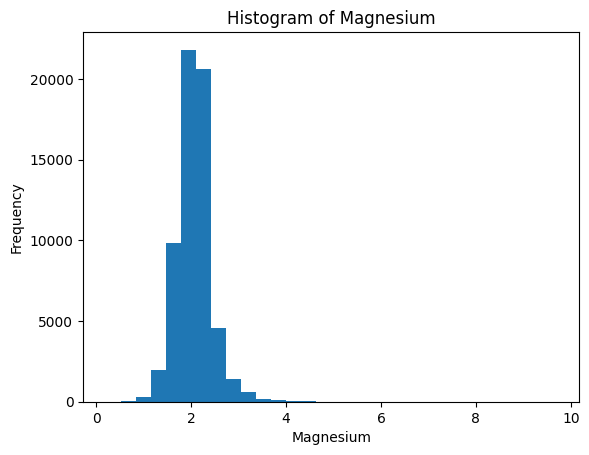

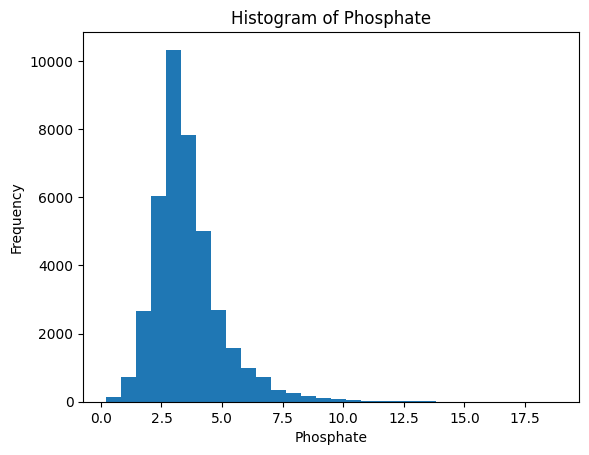

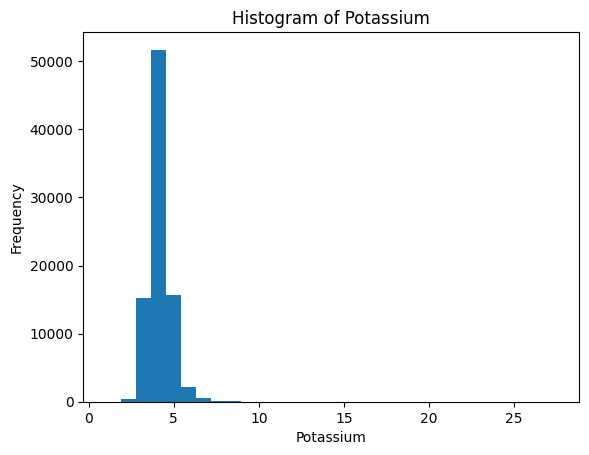

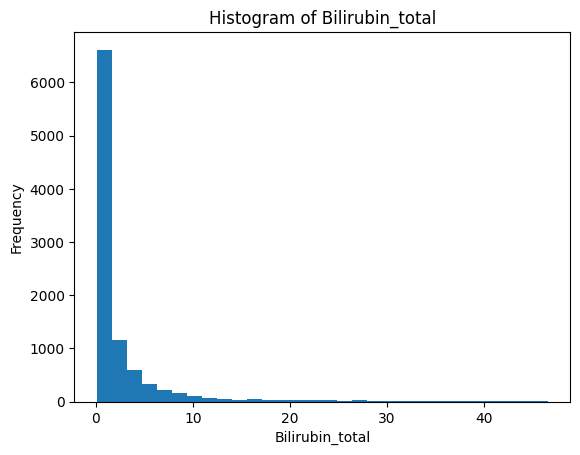

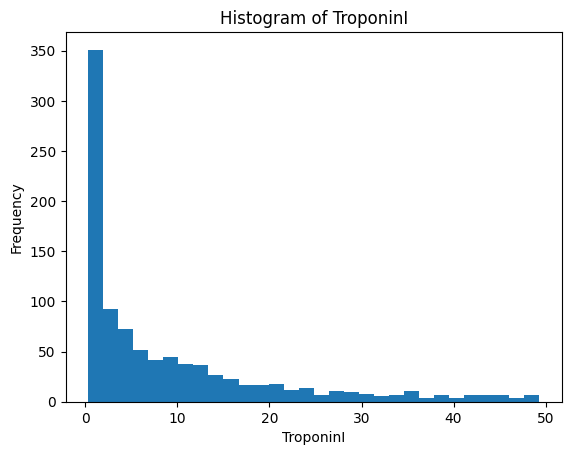

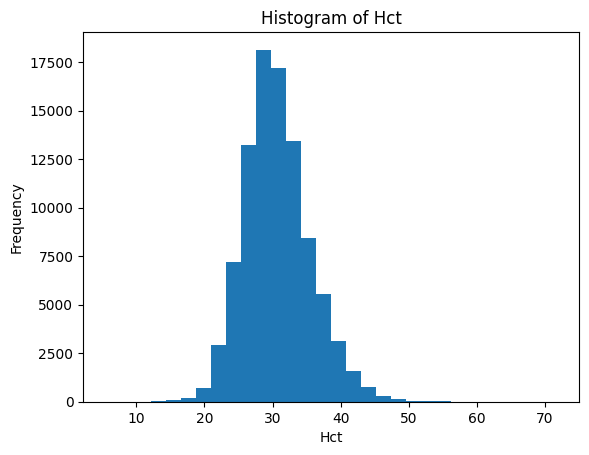

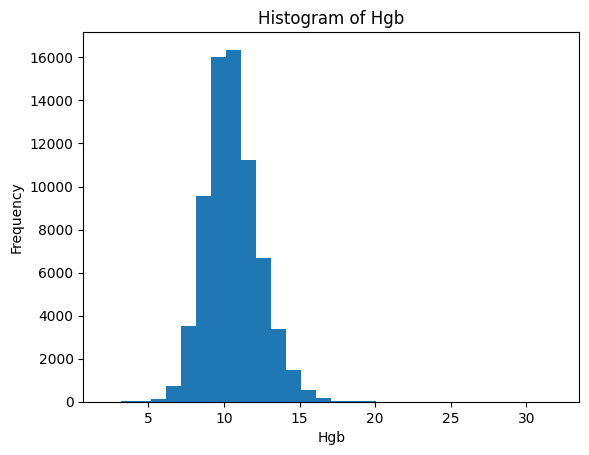

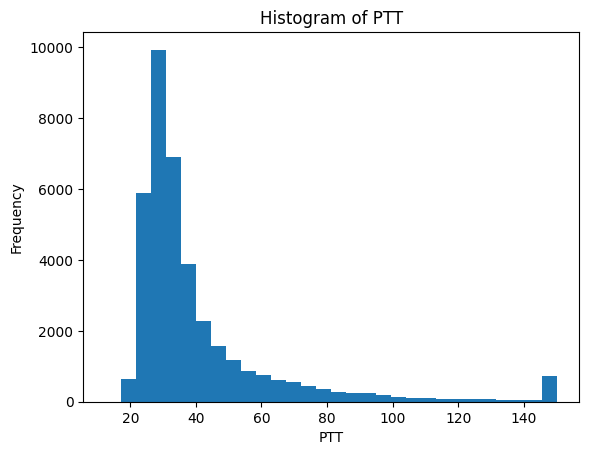

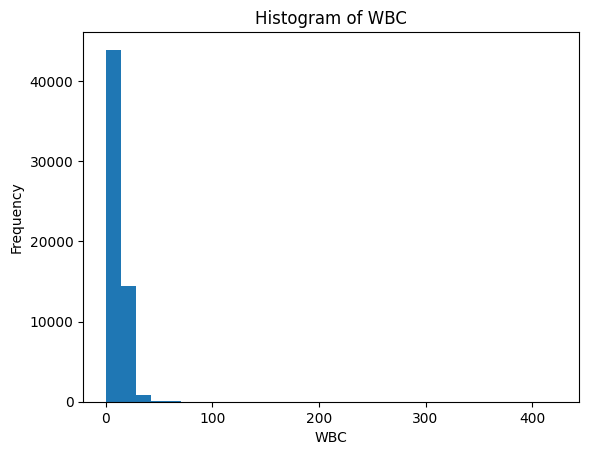

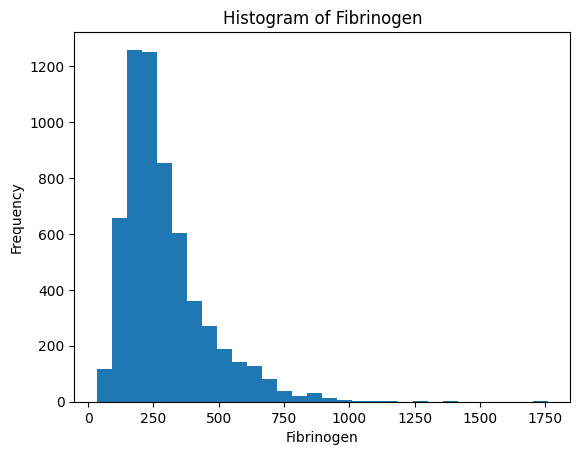

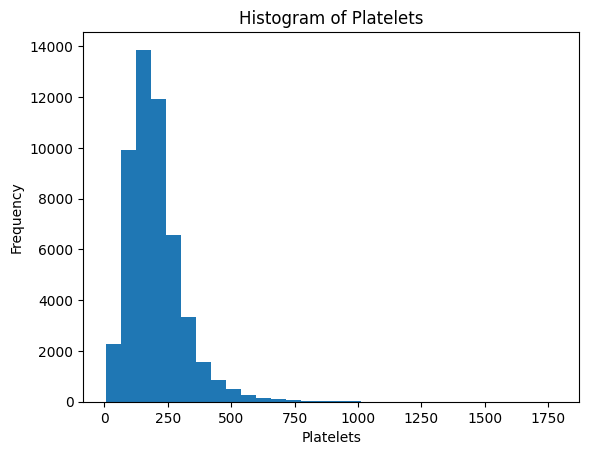

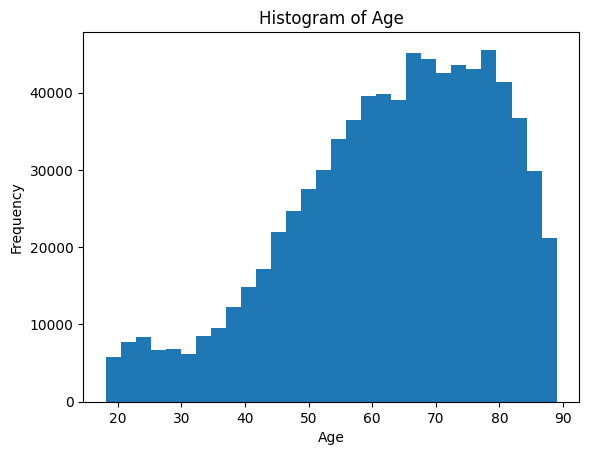

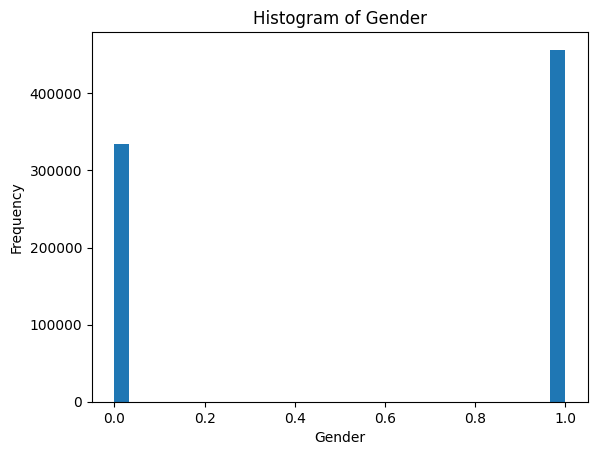

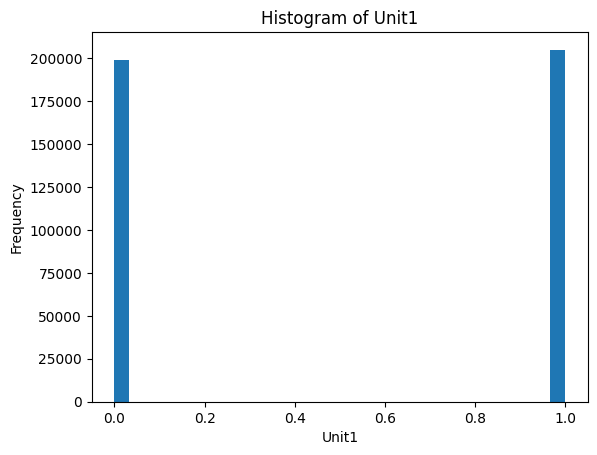

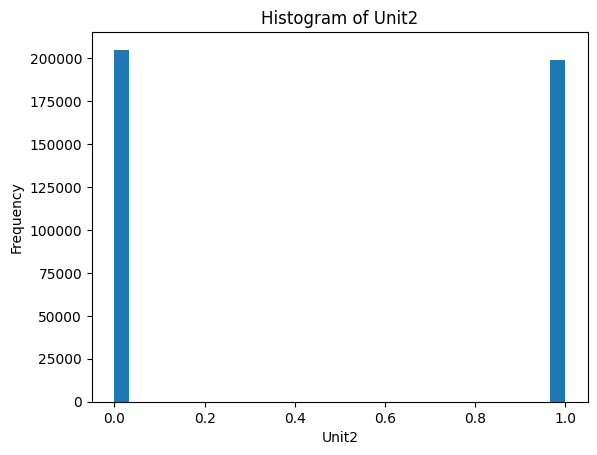

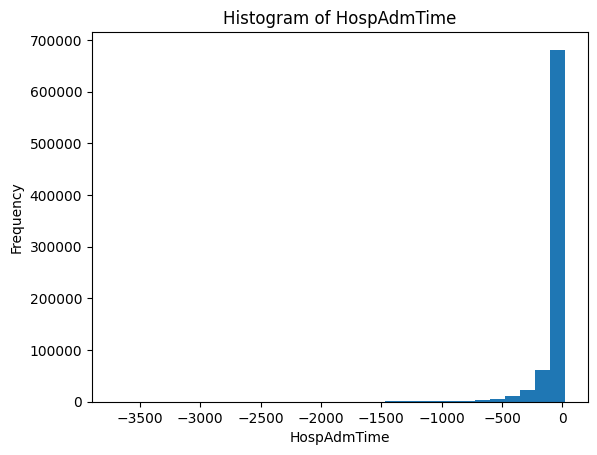

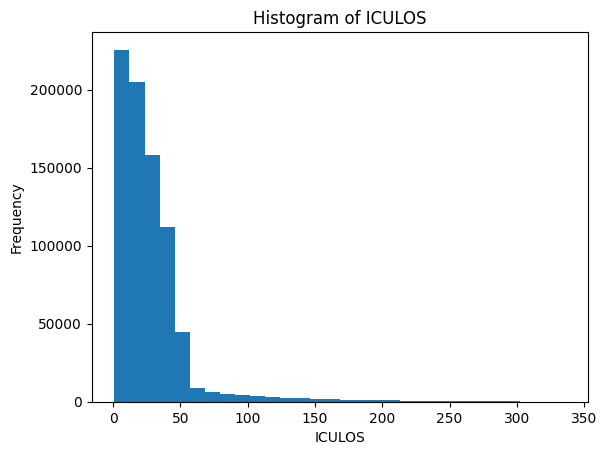

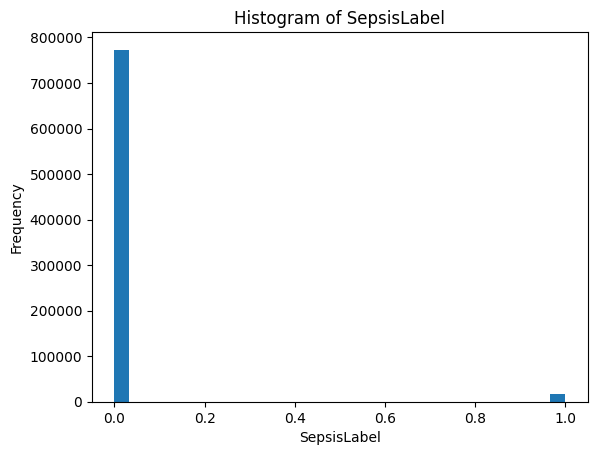

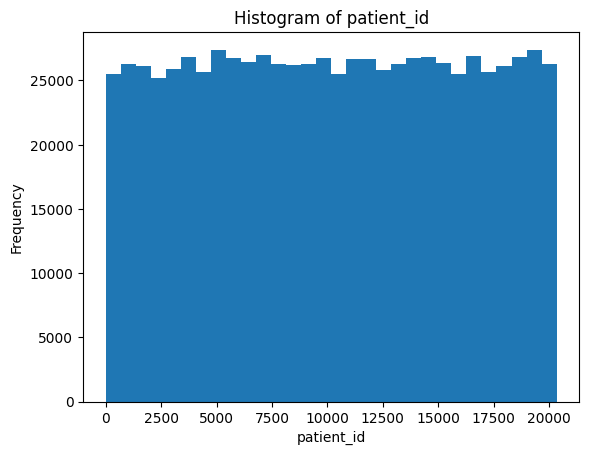

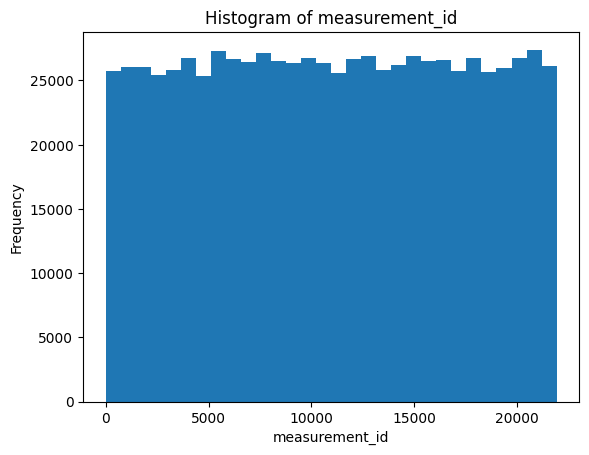

In [41]:
for column in full_df.columns:
    # Generate histogram for the current column
    plt.figure()  # Create a new figure for each column
    full_df[column].plot(kind='hist', bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()  # Display the histogram

In [ ]:
#sns.pairplot(full_df)

## Initial Interpolation

In [22]:
# interpolate full df
interpolation_limits = [1, 3, 5]

full_df_interpolated = [pd.concat([d.interpolate(limit=lim) for d in full_df_from_disk]) for lim in interpolation_limits]

In [23]:
value_availability = full_df.count().sort_values()/full_df.shape[0]
display(value_availability)

EtCO2               0.000000
TroponinI           0.001221
Bilirubin_direct    0.001496
Fibrinogen          0.007631
Bilirubin_total     0.012266
Alkalinephos        0.014593
AST                 0.014958
Lactate             0.034349
PTT                 0.048475
SaO2                0.049556
Calcium             0.049756
Phosphate           0.050488
Platelets           0.065171
Creatinine          0.066421
WBC                 0.075104
Magnesium           0.077803
HCO3                0.080506
BUN                 0.081593
Chloride            0.083239
PaCO2               0.087682
Hgb                 0.088357
BaseExcess          0.104251
Potassium           0.108624
pH                  0.114671
Hct                 0.117763
Glucose             0.122316
FiO2                0.141930
Temp                0.337757
Unit1               0.511317
Unit2               0.511317
DBP                 0.518742
SBP                 0.847888
O2Sat               0.879680
MAP                 0.897676
Resp          

We see that the columns `Age, ICULOS, HospAdmTime, Gender` and `SepsisLabel` are thankfully complete. No need to interpolate those, dropping those for further analysis. `EtCO2` is dropped for missing data entirely. One can also discuss dropping measurements with less than 5% overall data at this point.

EtCO2               0.000000
TroponinI           0.001221
Bilirubin_direct    0.001496
Fibrinogen          0.007631
Bilirubin_total     0.012266
Alkalinephos        0.014593
AST                 0.014958
Lactate             0.034349
PTT                 0.048475
SaO2                0.049556
Calcium             0.049756
Phosphate           0.050488
Platelets           0.065171
Creatinine          0.066421
WBC                 0.075104
Magnesium           0.077803
HCO3                0.080506
BUN                 0.081593
Chloride            0.083239
PaCO2               0.087682
Hgb                 0.088357
BaseExcess          0.104251
Potassium           0.108624
pH                  0.114671
Hct                 0.117763
Glucose             0.122316
FiO2                0.141930
Temp                0.337757
Unit1               0.511317
Unit2               0.511317
DBP                 0.518742
SBP                 0.847888
O2Sat               0.879680
MAP                 0.897676
Resp          

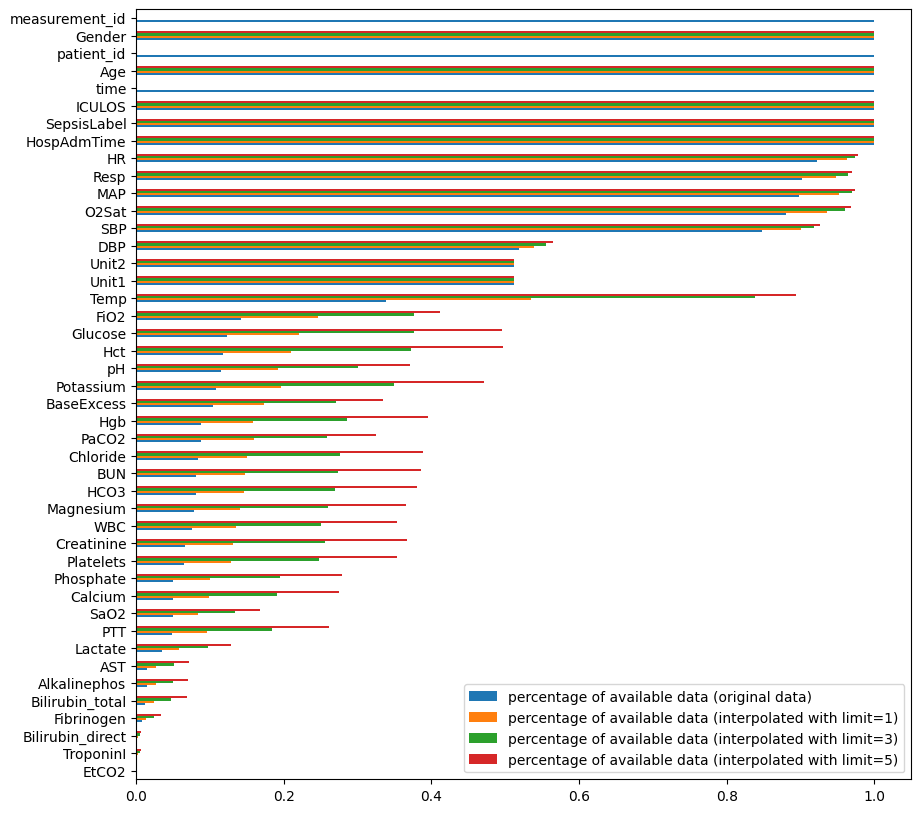

In [24]:
#dropped_cols = ["Age", "ICULOS", "HospAdmTime", "Gender", "SepsisLabel", "EtCO2"]

#full_df = full_df.drop(columns=dropped_cols)
#full_df_interpolated = [d.drop(columns=dropped_cols) for d in full_df_interpolated]

# recalculate with the smaller data frame.
value_availability = full_df.count().sort_values()/full_df.shape[0]
display(value_availability)

fig, ax = plt.subplots()

value_availability_interpolated = [
    d.count().sort_values()/full_df.shape[0] for d in full_df_interpolated
]

res = pd.concat([value_availability, *value_availability_interpolated],axis=1)

res.plot.barh(figsize=(10,10), ax=ax)
ax.legend(["percentage of available data (original data)",
           *[f"percentage of available data (interpolated with limit={lim})" for lim in interpolation_limits]])

In [25]:
full_df_interpolated = [add_patient_id_and_idx(d) for d in full_df_interpolated]
for limit, df in zip(interpolation_limits, full_df_interpolated):
  df.to_csv(f"/tmp/sepsis/training_setA_interpolated_{limit}.csv", index=False)

## Analyse Feature Contribution

### Using KNNs

In [26]:
# ref_df =full_df_interpolated[2]
# display(ref_df)

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id,measurement_id
0,0,69.0,95.0,35.720,98.000000,75.000000,54.0,20.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,2,0,0,0
1,1,67.0,95.5,35.915,94.000000,79.000000,65.0,16.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,3,0,0,0
2,2,63.0,97.5,36.110,78.500000,67.000000,53.0,15.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,4,0,0,0
3,3,60.0,99.0,36.305,88.000000,73.000000,58.0,17.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,5,0,0,0
4,4,58.0,96.0,36.500,83.000000,69.000000,56.0,16.0,NaN,NaN,...,119.0,80.58,1,NaN,NaN,-0.02,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,36,96.0,99.0,NaN,93.333333,65.553333,NaN,22.0,NaN,NaN,...,NaN,72.53,1,NaN,NaN,-26.63,37,0,20335,21922
790211,37,94.5,99.5,36.560,90.000000,63.330000,NaN,22.0,NaN,6.000000,...,129.0,72.53,1,NaN,NaN,-26.63,38,0,20335,21922
790212,38,100.0,100.0,36.560,98.000000,66.170000,NaN,22.5,NaN,4.333333,...,129.0,72.53,1,NaN,NaN,-26.63,39,0,20335,21922
790213,39,98.0,100.0,36.560,91.000000,63.670000,NaN,29.0,NaN,2.666667,...,129.0,72.53,1,NaN,NaN,-26.63,40,0,20335,21922


In [55]:
ref_df = pd.read_csv("/tmp/sepsis/training_setA_interpolated_3.csv")

display(ref_df)

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id,measurement_id
0,0,69.0,95.0,35.720,98.000000,75.000000,54.0,20.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,2,0,0,0
1,1,67.0,95.5,35.915,94.000000,79.000000,65.0,16.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,3,0,0,0
2,2,63.0,97.5,36.110,78.500000,67.000000,53.0,15.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,4,0,0,0
3,3,60.0,99.0,36.305,88.000000,73.000000,58.0,17.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,5,0,0,0
4,4,58.0,96.0,36.500,83.000000,69.000000,56.0,16.0,NaN,NaN,...,119.0,80.58,1,NaN,NaN,-0.02,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,36,96.0,99.0,NaN,93.333333,65.553333,NaN,22.0,NaN,NaN,...,NaN,72.53,1,NaN,NaN,-26.63,37,0,20335,21922
790211,37,94.5,99.5,36.560,90.000000,63.330000,NaN,22.0,NaN,6.000000,...,129.0,72.53,1,NaN,NaN,-26.63,38,0,20335,21922
790212,38,100.0,100.0,36.560,98.000000,66.170000,NaN,22.5,NaN,4.333333,...,129.0,72.53,1,NaN,NaN,-26.63,39,0,20335,21922
790213,39,98.0,100.0,36.560,91.000000,63.670000,NaN,29.0,NaN,2.666667,...,129.0,72.53,1,NaN,NaN,-26.63,40,0,20335,21922


In [28]:
print("std dev:")
display(ref_df.std().sort_values(ascending=False))

ref_availability = ref_df.count().sort_values(ascending=False)/ref_df.shape[0]

print("availability")
display(ref_availability)

std dev:


measurement_id      6317.035041
patient_id          5863.606214
AST                 1020.777944
Fibrinogen           158.915784
HospAdmTime          155.864937
Alkalinephos         146.593382
Platelets            108.562406
Glucose               46.993397
ICULOS                28.190940
time                  27.954160
PTT                   22.169718
SBP                   21.466224
BUN                   20.279263
HR                    16.942832
Age                   16.133632
MAP                   14.997445
DBP                   12.763712
SaO2                  11.971514
TroponinI             11.281380
PaCO2                  8.526780
WBC                    7.222523
Chloride               5.806818
Resp                   5.362928
Bilirubin_total        5.214619
Hct                    4.689102
Bilirubin_direct       4.571821
HCO3                   4.323812
BaseExcess             4.139719
O2Sat                  3.012240
Lactate                2.119999
Hgb                    1.692575
Creatini

availability


time                1.000000
Age                 1.000000
patient_id          1.000000
SepsisLabel         1.000000
ICULOS              1.000000
Gender              1.000000
measurement_id      1.000000
HospAdmTime         0.999990
HR                  0.974035
MAP                 0.969422
Resp                0.964281
O2Sat               0.960406
SBP                 0.918580
Temp                0.838959
DBP                 0.554711
Unit2               0.511317
Unit1               0.511317
Glucose             0.376229
FiO2                0.375932
Hct                 0.372580
Potassium           0.349089
pH                  0.300366
Hgb                 0.285478
Chloride            0.276158
BUN                 0.273393
BaseExcess          0.270038
HCO3                0.269473
Magnesium           0.260081
PaCO2               0.259050
Creatinine          0.255498
WBC                 0.250005
Platelets           0.247386
Phosphate           0.194143
Calcium             0.191309
PTT           

In [29]:
play_df = pd.DataFrame({"sepsis_label": [0,0,1,1,0,0,1,0,1,0], "measurement_id": [0,0,0,0,0,0,1,1,1,2]} )
display(play_df)

,sepsis_label,measurement_id
0,0,0
1,0,0
2,1,0
3,1,0
4,0,0
5,0,0
6,1,1
7,0,1
8,1,1
9,0,2


In [30]:
import math
def classify_pairs(df):
  """Take pairs of time series values and assign a sepsis_class as follows:
  00: A
  01: B
  10: C
  11: D

  Ensures that no comparisons are done between patients.
  """
  sepsis_label_df = df.diff()["SepsisLabel"].replace({1: "B", -1: "C"})
  sepsis_label_df[(sepsis_label_df == 0) & ((df == 0)["SepsisLabel"])] = "A"
  sepsis_label_df[(sepsis_label_df == 0) & ((df == 1)["SepsisLabel"])] = "D"
  sepsis_label_df[df.diff()["patient_id"] != 0] = math.nan

  _df = df.copy()
  _df["SepsisClass"] = sepsis_label_df
  return _df

In [31]:
print("distribution of transitions: A remains non-septic, B becomes septic, D remains septic")
sepsis_class_df = classify_pairs(ref_df)
display(sepsis_class_df["SepsisClass"].value_counts())
print("sanity check: overall (non-)septic timestamps")
display(ref_df["SepsisLabel"].value_counts())

distribution of transitions: A remains non-septic, B becomes septic, D remains septic


A    752946
D     15346
B      1587
Name: SepsisClass, dtype: int64

sanity check: overall (non-)septic timestamps


0    773079
1     17136
Name: SepsisLabel, dtype: int64

In [37]:
import xgboost as xgb

# try random forest as outlined here: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# one hot encoding is skipped (we only have binary or continous data, nothing categorical)
# we also don't have temporal variables

# we can try the following data sets:
# original data (classified as sepsis/non-sepsis)
# original data (classified as transitions)
# pairs of data (classified as transitions)

# todo: should data be normalized, like pixels (to [0, 1]?)
labels = np.array(ref_df['SepsisLabel'])
ref_df_nosepsis = ref_df.drop('SepsisLabel', axis = 1)
ref_df_names = list(ref_df_nosepsis.columns)
ref_df_as_array = np.array(ref_df_nosepsis)


# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(ref_df_as_array, labels, test_size = 0.25, random_state = 42)

### sklearn trees (hist gradient boosting)

In [38]:
# Import the model we are using
# Random Forest does not work due to NaN values.
# HistGradientBoostingClassifier is suggested as alternative but that one does
#  not give importances.
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingClassifier # Instantiate model with 1000 decision trees
# rf = RandomForestRegressor(n_estimators = 1000, random_state = 42) # Train the model on training data
rf = HistGradientBoostingClassifier(verbose=1, max_depth=12, max_iter=100, random_state = 42)
est = rf.fit(train_features, train_labels);

Binning 0.183 GB of training data: 1.211 s
Binning 0.020 GB of validation data: 0.063 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.09888, val loss: 0.09924, in 0.117s
[2/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.09623, val loss: 0.09675, in 0.142s
[3/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.09433, val loss: 0.09494, in 0.145s
[4/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.09286, val loss: 0.09363, in 0.163s
[5/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.09162, val loss: 0.09257, in 0.155s
[6/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.09060, val loss: 0.09163, in 0.160s
[7/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.08967, val loss: 0.09085, in 0.141s
[8/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.08888, val loss: 0.09021, in 0.153s
[9/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.08817, val loss: 0.08949, in 0.144s
[10/100] 1 tree, 31 leaves, max depth = 10, tr

In [39]:
# use a confusion matrix here to get a better idea of how good we are:
# https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/

print(f"test data accuracy: {est.score(train_features, train_labels)}")
print(f"validation data accuracy: {est.score(test_features, test_labels)}")

test data accuracy: 0.9793946286325572
validation data accuracy: 0.9785678852364417


In [58]:
# runtime:
# model iterations | time
# 10               | 2:26
# 20               | 4:08
# 30               | 6 min (?)
# 40               | 7:54
# 100              | 17:19
# 700              | 1:51:34
# As this has complexity in O(n^2), where n is the number of model parameters
# (roughly 50 in our case), we expect this value to decrease a lot after parameter
# elimination


# see here: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
from sklearn.inspection import permutation_importance


train_result = permutation_importance(
    rf, train_features, train_labels, n_repeats=3, random_state=42, n_jobs=-1
)
test_results = permutation_importance(
    rf, test_features, test_labels, n_repeats=3, random_state=42, n_jobs=-1
)
sorted_importances_idx = train_result.importances_mean.argsort()

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=ref_df.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=ref_df.columns[sorted_importances_idx],
)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

KeyboardInterrupt: ignored

In [ ]:
# this cell takes a LOT of time.

from sklearn.model_selection import LearningCurveDisplay
LearningCurveDisplay.from_estimator(est, train_features, train_labels, n_jobs=-1)

NameError: ignored

### XGBoost

In [40]:
# prepare

# prepare data for use with XGBoost.
# from https://www.datacamp.com/tutorial/xgboost-in-python
dtrain_clf = xgb.DMatrix(train_features, train_labels, feature_names=ref_df_names, enable_categorical=True)
dtest_clf = xgb.DMatrix(test_features, test_labels, feature_names=ref_df_names, enable_categorical=True)

# train
# to convert the SepsisClass (which is not used yet) you have to use a numerical
# representation, where the following snippet might come in handy:
# Encode y to numeric
# y_encoded = OrdinalEncoder().fit_transform(y)

params = {"objective": "binary:logistic", "tree_method": "gpu_hist"}

n = 1000
evals = [(dtrain_clf, "train"), (dtest_clf, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10, # Every ten rounds
   early_stopping_rounds=50 # Activate early stopping
)

# evaluate
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_clf)

[0]	train-logloss:0.45779	validation-logloss:0.45806
[10]	train-logloss:0.09073	validation-logloss:0.09274
[20]	train-logloss:0.07856	validation-logloss:0.08279
[30]	train-logloss:0.07392	validation-logloss:0.07951
[40]	train-logloss:0.07133	validation-logloss:0.07779
[50]	train-logloss:0.06785	validation-logloss:0.07535
[60]	train-logloss:0.06500	validation-logloss:0.07310
[70]	train-logloss:0.06310	validation-logloss:0.07161
[80]	train-logloss:0.06080	validation-logloss:0.06994
[90]	train-logloss:0.05841	validation-logloss:0.06829
[100]	train-logloss:0.05574	validation-logloss:0.06638
[110]	train-logloss:0.05397	validation-logloss:0.06501
[120]	train-logloss:0.05213	validation-logloss:0.06364
[130]	train-logloss:0.05098	validation-logloss:0.06286
[140]	train-logloss:0.04966	validation-logloss:0.06180
[150]	train-logloss:0.04857	validation-logloss:0.06106
[160]	train-logloss:0.04714	validation-logloss:0.05992
[170]	train-logloss:0.04594	validation-logloss:0.05911
[180]	train-logloss:0

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

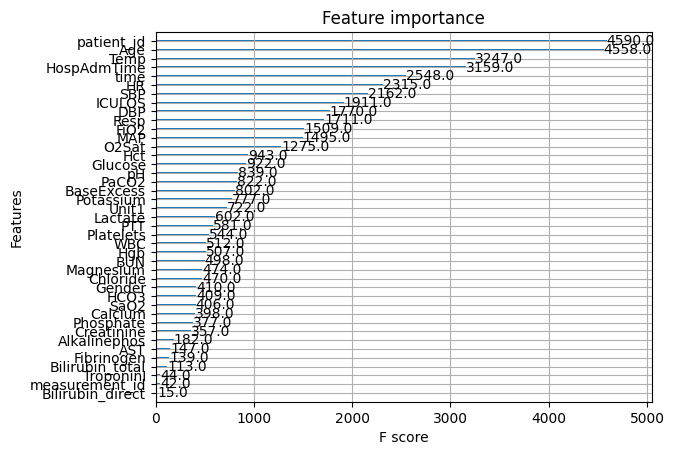

In [41]:
from xgboost import plot_importance
plot_importance(model)

In [42]:
ref_df.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id,measurement_id
0,0,69.0,95.0,35.720,98.0,75.0,54.0,20.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,2,0,0,0
1,1,67.0,95.5,35.915,94.0,79.0,65.0,16.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,3,0,0,0
2,2,63.0,97.5,36.110,78.5,67.0,53.0,15.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,4,0,0,0
3,3,60.0,99.0,36.305,88.0,73.0,58.0,17.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,5,0,0,0
4,4,58.0,96.0,36.500,83.0,69.0,56.0,16.0,NaN,NaN,...,119.0,80.58,1,NaN,NaN,-0.02,6,0,0,0


In [43]:
ref_df.groupby(["patient_id", "SepsisLabel"]).first()

,,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,measurement_id
patient_id,SepsisLabel,,,,,,,,,,,,,,,,,,,,,
0,0,0,69.0,95.0,35.72,98.0,75.00,54.00,20.0,NaN,-1.0,...,30.7,NaN,119.0,80.58,1,NaN,NaN,-0.02,2,0
1,0,0,55.5,98.5,34.67,144.0,98.50,70.75,12.5,NaN,-2.0,...,6.1,NaN,151.0,73.95,1,NaN,NaN,-0.01,2,1
2,0,0,62.0,95.0,36.72,98.0,67.33,NaN,20.0,NaN,NaN,...,10.1,NaN,313.0,86.77,1,NaN,NaN,-118.46,1,2
3,0,0,73.0,97.0,36.61,124.0,76.00,59.00,22.0,NaN,NaN,...,3.9,NaN,245.0,69.01,0,NaN,NaN,-0.02,2,3
4,0,0,31.5,99.0,36.67,96.5,65.33,NaN,13.5,NaN,NaN,...,6.3,NaN,211.0,58.88,1,1.0,0.0,-0.04,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20332,0,0,77.0,95.0,37.00,93.0,48.00,47.00,27.0,NaN,1.0,...,11.1,515.0,325.0,81.44,0,0.0,1.0,-215.46,1,21918
20333,0,0,61.0,95.0,36.11,114.0,68.00,49.00,20.0,NaN,10.0,...,5.2,NaN,194.0,80.01,0,0.0,1.0,-0.02,1,21919
20334,0,0,84.5,100.0,36.90,127.0,79.50,57.50,13.0,NaN,1.0,...,6.5,246.0,96.0,68.30,0,NaN,NaN,-344.50,5,21920


In [ ]:
# Reimplement CaptureStatistics from "a study of kNN using ICU multivariate data"

# 1) z-score normalization
# 2) find min, max, mean, moving average for each (multivariate) time series
# 3) find min, max, mean, moving average for Q (the time series that should be classified).
# 4) find k nearest neighbors using kNN
# 5) apply majority vote, classify Q.

## Filtering and Interpolation

In [44]:
from sklearn.feature_selection import SelectFromModel

In [56]:
# Get n most important features
feature_names = model.feature_names

# Get the feature importance dictionary
feature_importance = model.get_score(importance_type="gain")

# Sort the feature importance in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=False)

# Get the top N most important features
top_n_features = sorted_feature_importance[:-10]  # Replace N with the desired number of features
to_drop_features = sorted_feature_importance[-10:]

# Get the actual feature names of the top features
top_feature_names = [feature for feature, _ in top_n_features]
to_top_feature_names = [feature for feature, _ in to_drop_features]

In [57]:
top_feature_names

['O2Sat',
 'MAP',
 'TroponinI',
 'Resp',
 'Glucose',
 'DBP',
 'HR',
 'pH',
 'SBP',
 'PaCO2',
 'Hgb',
 'Hct',
 'SaO2',
 'Temp',
 'PTT',
 'time',
 'Potassium',
 'Bilirubin_total',
 'BaseExcess',
 'Platelets',
 'Phosphate',
 'WBC',
 'Gender',
 'Fibrinogen',
 'BUN',
 'patient_id',
 'Chloride',
 'Age',
 'measurement_id',
 'Alkalinephos',
 'Creatinine']

In [58]:
to_top_feature_names

['Lactate',
 'HCO3',
 'HospAdmTime',
 'Calcium',
 'Magnesium',
 'FiO2',
 'Bilirubin_direct',
 'AST',
 'Unit1',
 'ICULOS']

In [62]:
# Select subsample of data frame
red_df = ref_df.drop(to_top_feature_names, axis=1)


In [63]:
red_df.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit2,SepsisLabel,patient_id,measurement_id
0,0,69.0,95.0,35.720,98.0,75.0,54.0,20.0,NaN,NaN,...,NaN,NaN,NaN,NaN,80.58,1,NaN,0,0,0
1,1,67.0,95.5,35.915,94.0,79.0,65.0,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,80.58,1,NaN,0,0,0
2,2,63.0,97.5,36.110,78.5,67.0,53.0,15.0,NaN,NaN,...,NaN,NaN,NaN,NaN,80.58,1,NaN,0,0,0
3,3,60.0,99.0,36.305,88.0,73.0,58.0,17.0,NaN,NaN,...,NaN,NaN,NaN,NaN,80.58,1,NaN,0,0,0
4,4,58.0,96.0,36.500,83.0,69.0,56.0,16.0,NaN,NaN,...,25.9,30.7,NaN,119.0,80.58,1,NaN,0,0,0


Interpolation on remaining missing values

In [64]:
# Display amount of remaining missing values
value_availability = red_df.count().sort_values()/red_df.shape[0]
display(value_availability)

EtCO2              0.000000
TroponinI          0.004759
Fibrinogen         0.024605
Bilirubin_total    0.047445
Alkalinephos       0.049297
SaO2               0.133324
PTT                0.183455
Phosphate          0.194143
Platelets          0.247386
WBC                0.250005
Creatinine         0.255498
PaCO2              0.259050
BaseExcess         0.270038
BUN                0.273393
Chloride           0.276158
Hgb                0.285478
pH                 0.300366
Potassium          0.349089
Hct                0.372580
Glucose            0.376229
Unit2              0.511317
DBP                0.554711
Temp               0.838959
SBP                0.918580
O2Sat              0.960406
Resp               0.964281
MAP                0.969422
HR                 0.974035
SepsisLabel        1.000000
time               1.000000
Age                1.000000
patient_id         1.000000
Gender             1.000000
measurement_id     1.000000
dtype: float64

Several columns still have a massiv amount of missing data, i.e. less than 10% available data. Susequently, all columns with less than 5% overall data will be dropped.

In [65]:
threshold = 0.90  # Set the threshold for missing data

# Calculate the number of non-null values in each column
non_null_counts = red_df.notnull().sum()

# Calculate the percentage of missing full_df in each column
missing_percentages = 1 - (non_null_counts / len(red_df))

# Identify columns with missing data exceeding the threshold
columns_to_drop = missing_percentages[missing_percentages > threshold].index

# Drop columns with excessive missing data
red_df = red_df.drop(columns=columns_to_drop)

# Display the DataFrame after dropping columns
print("Dropped columns (less that 10% availble data):", columns_to_drop)

Dropped columns (less that 10% availble data): Index(['EtCO2', 'Alkalinephos', 'Bilirubin_total', 'TroponinI', 'Fibrinogen'], dtype='object')


Interpolate remaining missing data.

In [66]:
# Forward- and backward fill missing values at the start of each patient's data
red_df_filled = red_df.groupby('patient_id', group_keys=False).apply(lambda group: group.ffill())
red_df_filled = red_df_filled.groupby('patient_id', group_keys=False).apply(lambda group: group.bfill())

In [77]:
# Interpolate missing values within each patient's data using linear interpolation
df_int = red_df_filled.groupby('patient_id', group_keys=False).apply(lambda x: x.interpolate(method='linear'))

In [78]:
df_int.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,pH,...,Hgb,PTT,WBC,Platelets,Age,Gender,Unit2,SepsisLabel,patient_id,measurement_id
0,0,69.0,95.0,35.720,98.0,75.0,54.0,20.0,-1.0,7.35,...,11.00,25.9,30.7,119.0,80.58,1,NaN,0,0,0
1,1,67.0,95.5,35.915,94.0,79.0,65.0,16.0,-1.0,7.35,...,10.95,25.9,30.7,119.0,80.58,1,NaN,0,0,0
2,2,63.0,97.5,36.110,78.5,67.0,53.0,15.0,-1.0,7.35,...,10.90,25.9,30.7,119.0,80.58,1,NaN,0,0,0
3,3,60.0,99.0,36.305,88.0,73.0,58.0,17.0,-1.0,7.35,...,10.85,25.9,30.7,119.0,80.58,1,NaN,0,0,0
4,4,58.0,96.0,36.500,83.0,69.0,56.0,16.0,-1.0,7.35,...,10.80,25.9,30.7,119.0,80.58,1,NaN,0,0,0


For patients with completely missing variables, fill missing values with variable mean over all available patients.

In [79]:
vars = df_int.columns
# Calculate the mean for the variables over all patients
mean_values = df_int[vars].mean()

# Iterate over the variables and fill missing values with the corresponding mean
for variable in vars:
    df_int[variable] = df_int[variable].fillna(mean_values[variable])

In [80]:
df_int.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,pH,...,Hgb,PTT,WBC,Platelets,Age,Gender,Unit2,SepsisLabel,patient_id,measurement_id
0,0,69.0,95.0,35.720,98.0,75.0,54.0,20.0,-1.0,7.35,...,11.00,25.9,30.7,119.0,80.58,1,0.492899,0,0,0
1,1,67.0,95.5,35.915,94.0,79.0,65.0,16.0,-1.0,7.35,...,10.95,25.9,30.7,119.0,80.58,1,0.492899,0,0,0
2,2,63.0,97.5,36.110,78.5,67.0,53.0,15.0,-1.0,7.35,...,10.90,25.9,30.7,119.0,80.58,1,0.492899,0,0,0
3,3,60.0,99.0,36.305,88.0,73.0,58.0,17.0,-1.0,7.35,...,10.85,25.9,30.7,119.0,80.58,1,0.492899,0,0,0
4,4,58.0,96.0,36.500,83.0,69.0,56.0,16.0,-1.0,7.35,...,10.80,25.9,30.7,119.0,80.58,1,0.492899,0,0,0


In [81]:
# Check for remaining missing values
df_int.isnull().values.any()

False

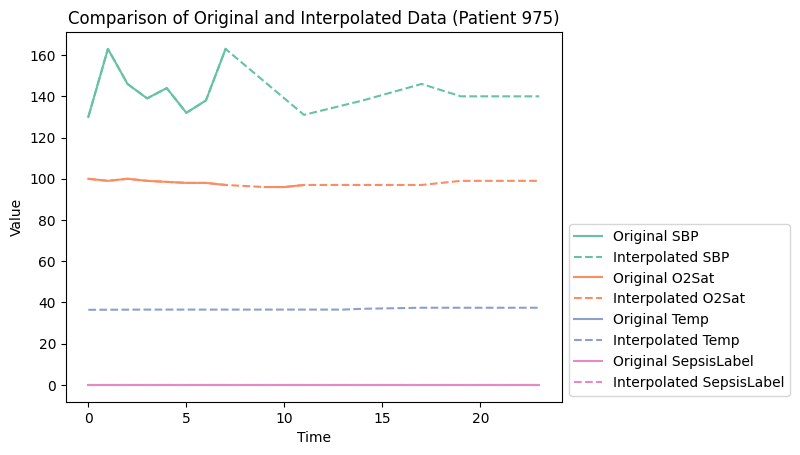

In [82]:
# Example plot of interpolated data
# Choose a specific patient for plotting (e.g., patient_id = 0)
patient_id = 975

# Specify the columns to plot
columns_to_plot = ["SBP", "O2Sat", "Temp", "SepsisLabel"]

# Generate a color palette based on the number of variables
color_palette = sns.color_palette('Set2', len(columns_to_plot))

# Filter the original and interpolated data for the selected patient
original_patient_data = full_df[full_df['patient_id'] == patient_id]
interpolated_patient_data = df_int[df_int['patient_id'] == patient_id]

# Set up the figure and subplot
fig, ax = plt.subplots()

# Iterate over the columns and plot the original and interpolated data
for variable, color in zip(columns_to_plot, color_palette):
    # Plot the original data
    ax.plot(original_patient_data['time'], original_patient_data[variable], label=f'Original {variable}', color=color)

    # Plot the interpolated data
    ax.plot(interpolated_patient_data['time'], interpolated_patient_data[variable], label=f'Interpolated {variable}', linestyle='--', color=color)


# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title(f'Comparison of Original and Interpolated Data (Patient {patient_id})')

# Add legend
ax.legend(bbox_to_anchor=(1, 0.5), loc="upper left")

# Show the plot
plt.show()

## Time Series Prediction Models

### Create test and train set

In [99]:
df_int = df_int.drop(["measurement_id"], axis=1)

In [196]:
# To do: apply to whole sample
n = 80  # Number of patients to select

# Get unique patient IDs
unique_patients = df_int['patient_id'].unique()

# Select a subset of n unique patients
selected_patients = pd.Series(unique_patients).sample(n=n, random_state=2)

# Filter the data frame based on the selected patients and preserve the order
df_int_subs = df_int[df_int['patient_id'].isin(selected_patients)].sort_values(by=['patient_id', 'time'])

In [197]:
unique_patients = df_int_subs['patient_id'].unique()
print(unique_patients)
len(unique_patients)

[  551   641   823  1396  1946  2959  3056  3118  3385  3443  4234  4270
  4628  4763  4853  4948  5054  5881  5932  6162  6283  6887  6930  7284
  7352  7377  7576  8145  8988  9031  9170  9353  9573  9813 10131 10165
 10773 10882 11285 11566 11864 12171 12283 12858 13207 13371 13544 13873
 14024 14428 14734 15018 15140 15319 15438 15564 15917 16105 16192 16194
 16349 16358 16551 16706 17165 17324 17513 18112 18132 18204 18270 18914
 19247 19290 19343 19445 19840 19860 19861 20093]


80

In [198]:
unique_patients = df_int_subs['patient_id'].unique()

# Split the patients into train and test sets
train_patients, test_patients = train_test_split(unique_patients, test_size=0.1, random_state=42)

# Filter the data based on the train and test patients
train_data = df_int_subs[df_int_subs['patient_id'].isin(train_patients)]
test_data = df_int_subs[df_int_subs['patient_id'].isin(test_patients)]

In [212]:
# Separate features and labels
train_X = train_data.drop('SepsisLabel', axis=1)
train_y = train_data['SepsisLabel']
test_X = test_data.drop('SepsisLabel', axis=1)
test_y = test_data['SepsisLabel']

# Display the shapes of the train and test sets
print("Train Patients Num:", len(train_X['patient_id'].unique()))
print('Train features shape:', train_X.shape)
print('Train labels shape:', train_y.shape)
print("Test Patients Num:", len(test_X['patient_id'].unique()))
print('Test features shape:', test_X.shape)
print('Test labels shape:', test_y.shape)

# TO DO: Check for dublicate patients in train and test
# TO DO: Stratify
# TO DO: Train, Test, Val

Train Patients Num: 72
Train features shape: (2719, 27)
Train labels shape: (2719,)
Test Patients Num: 8
Test features shape: (472, 27)
Test labels shape: (472,)


### LSTM

In [200]:
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [201]:
# # Scale the features using MinMaxScaler within each patient group
# scaler = MinMaxScaler()

# def scale_within_group(data):
#     return scaler.fit_transform(data)

# train_X_scaled = train_X.groupby('patient_id').apply(scale_within_group)
# test_X_scaled = test_X.groupby('patient_id').apply(scale_within_group)

# To Do: apply proper scaling

In [202]:
train_data.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,pH,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,Unit2,SepsisLabel,patient_id
24085,0,65.5,99.0,36.890000,85.5,58.17,60.769235,12.5,0.05546,7.392353,...,29.9,10.400000,28.70,7.700000,182.000000,52.95,0,0.492899,0,641
24086,1,65.5,99.0,36.890000,85.5,58.17,60.769235,12.5,0.05546,7.392353,...,29.9,10.400000,28.70,7.700000,182.000000,52.95,0,0.492899,0,641
24087,2,66.0,99.0,36.890000,89.0,55.67,60.769235,12.0,0.05546,7.392353,...,30.3,10.522222,28.70,7.994444,186.333333,52.95,0,0.492899,0,641
24088,3,65.0,100.0,36.890000,84.0,58.67,60.769235,13.0,0.05546,7.392353,...,30.7,10.644444,28.27,8.288889,190.666667,52.95,0,0.492899,0,641
24089,4,67.0,100.0,37.093333,100.0,68.00,60.769235,12.0,0.05546,7.392353,...,31.1,10.766667,27.84,8.583333,195.000000,52.95,0,0.492899,0,641


In [213]:
features = train_data.loc[:,train_data.columns!="SepsisLabel"].columns

n_features = len(features)-1

In [224]:
window_size = 5

# Define a function to create sliding windows for each patient
def create_sliding_windows(data):
    windows = []
    for i in range(len(data) - window_size + 1):
        window = data.iloc[i:i+window_size]
        windows.append(window)
    return windows

In [225]:
# Create sliding windows for each patient in the training data
train_windows = train_data.groupby('patient_id').apply(create_sliding_windows)

In [226]:
train_windows

patient_id
641      [[time, HR, O2Sat, Temp, SBP], [time, HR, O2Sa...
823      [[time, HR, O2Sat, Temp, SBP], [time, HR, O2Sa...
1396     [[time, HR, O2Sat, Temp, SBP], [time, HR, O2Sa...
1946     [[time, HR, O2Sat, Temp, SBP], [time, HR, O2Sa...
2959     [[time, HR, O2Sat, Temp, SBP], [time, HR, O2Sa...
                               ...                        
19445    [[time, HR, O2Sat, Temp, SBP], [time, HR, O2Sa...
19840    [[time, HR, O2Sat, Temp, SBP], [time, HR, O2Sa...
19860    [[time, HR, O2Sat, Temp, SBP], [time, HR, O2Sa...
19861    [[time, HR, O2Sat, Temp, SBP], [time, HR, O2Sa...
20093    [[time, HR, O2Sat, Temp, SBP], [time, HR, O2Sa...
Length: 72, dtype: object

In [227]:
train_data.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,pH,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,Unit2,SepsisLabel,patient_id
24085,0,65.5,99.0,36.890000,85.5,58.17,60.769235,12.5,0.05546,7.392353,...,29.9,10.400000,28.70,7.700000,182.000000,52.95,0,0.492899,0,641
24086,1,65.5,99.0,36.890000,85.5,58.17,60.769235,12.5,0.05546,7.392353,...,29.9,10.400000,28.70,7.700000,182.000000,52.95,0,0.492899,0,641
24087,2,66.0,99.0,36.890000,89.0,55.67,60.769235,12.0,0.05546,7.392353,...,30.3,10.522222,28.70,7.994444,186.333333,52.95,0,0.492899,0,641
24088,3,65.0,100.0,36.890000,84.0,58.67,60.769235,13.0,0.05546,7.392353,...,30.7,10.644444,28.27,8.288889,190.666667,52.95,0,0.492899,0,641
24089,4,67.0,100.0,37.093333,100.0,68.00,60.769235,12.0,0.05546,7.392353,...,31.1,10.766667,27.84,8.583333,195.000000,52.95,0,0.492899,0,641


In [233]:
# Prepare training data
train_X = np.empty((0, window_size, n_features))
train_y = np.empty((0,))
for windows, patient_data in zip(train_windows, train_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    #print(windows)
    X = np.stack(windows)[:, :, :n_features]
    y = np.stack(windows)[:, -1, -2]  # TO DO: indexing correct?
    train_X = np.concatenate((train_X, X))
    train_y = np.concatenate((train_y, y))

In [234]:
train_y

array([0., 0., 0., ..., 0., 0., 0.])

In [235]:
class_weights_array = compute_class_weight(class_weight='balanced',classes=np.unique(train_y), y=train_y)
class_weights_array

array([ 0.51460627, 17.61594203])

In [236]:
# Define class weights
class_weights = dict((i, weight) for i, weight in enumerate(class_weights_array  ))
class_weights

{0: 0.5146062658763759, 1: 17.615942028985508}

In [237]:
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(window_size, n_features)))
model.add(Dense(1, activation='sigmoid'))

In [238]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [239]:
# Train the model
model.fit(train_X, train_y, epochs=21, batch_size=32, class_weight=class_weight)

Epoch 1/21
76/76 [==============================] - 3s 6ms/step - loss: 0.7153
Epoch 2/21
76/76 [==============================] - 0s 6ms/step - loss: 0.6236
Epoch 3/21
76/76 [==============================] - 0s 6ms/step - loss: 0.6078
Epoch 4/21
76/76 [==============================] - 0s 5ms/step - loss: 0.5939
Epoch 5/21
76/76 [==============================] - 0s 5ms/step - loss: 0.5667
Epoch 6/21
76/76 [==============================] - 1s 8ms/step - loss: 0.5459
Epoch 7/21
76/76 [==============================] - 1s 9ms/step - loss: 0.5248
Epoch 8/21
76/76 [==============================] - 1s 7ms/step - loss: 0.4766
Epoch 9/21
76/76 [==============================] - 1s 9ms/step - loss: 0.4740
Epoch 10/21
76/76 [==============================] - 1s 8ms/step - loss: 0.4353
Epoch 11/21
76/76 [==============================] - 1s 8ms/step - loss: 0.4066
Epoch 12/21
76/76 [==============================] - 1s 8ms/step - loss: 0.3892
Epoch 13/21
76/76 [==============================

In [240]:
# Create sliding windows for each patient in the test data
test_windows = test_data.groupby('patient_id').apply(create_sliding_windows)

In [241]:
# Prepare test data
test_X = np.empty((0, window_size, n_features))
test_y_true = np.empty((0,))
for windows, patient_data in zip(test_windows, test_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    X = np.stack(windows)[:, :, :n_features]
    y_true = np.stack(windows)[:, -1, -2]  # Assuming sepsis_occurrence is the last column
    test_X = np.concatenate((test_X, X))
    test_y_true = np.concatenate((test_y_true, y_true))

In [242]:
test_y_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [243]:
sum(test_y_true)/len(test_y_true)

0.020454545454545454

In [244]:
# Make predictions on the test data
test_y_pred = model.predict(test_X)

# Convert predictions to binary values
test_y_pred = (test_y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(test_y_true, test_y_pred)
precision = precision_score(test_y_true, test_y_pred)
recall = recall_score(test_y_true, test_y_pred)
auc_roc = roc_auc_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC Score:", auc_roc)

14/14 [==============================] - 0s 2ms/step
Accuracy: 0.8045454545454546
Precision: 0.05747126436781609
Recall: 0.5555555555555556
AUC-ROC Score: 0.6826501675689611


In [245]:
test_y_pred.sum()

87

In [246]:
test_y_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

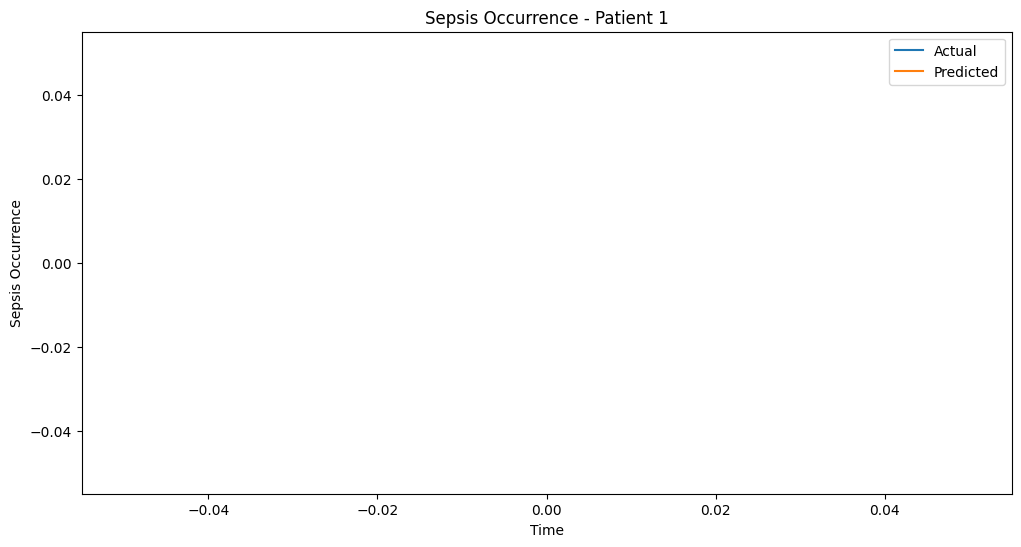

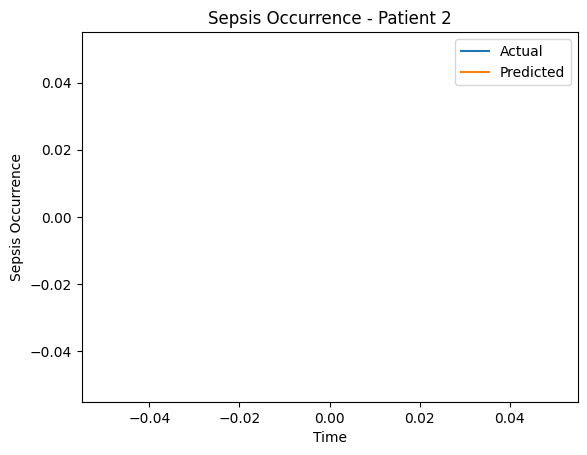

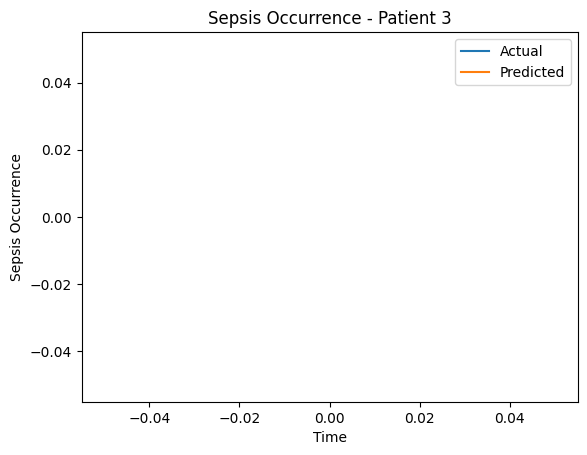

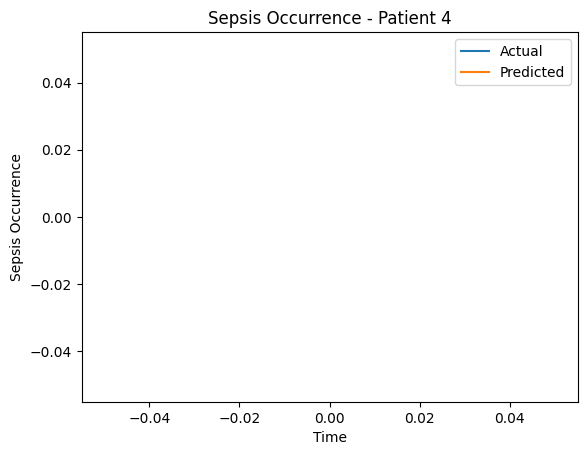

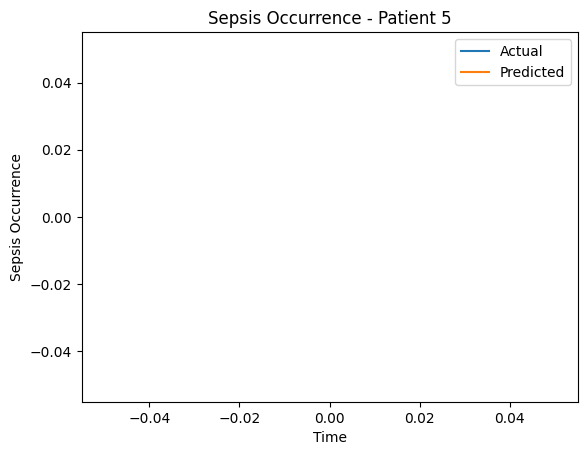

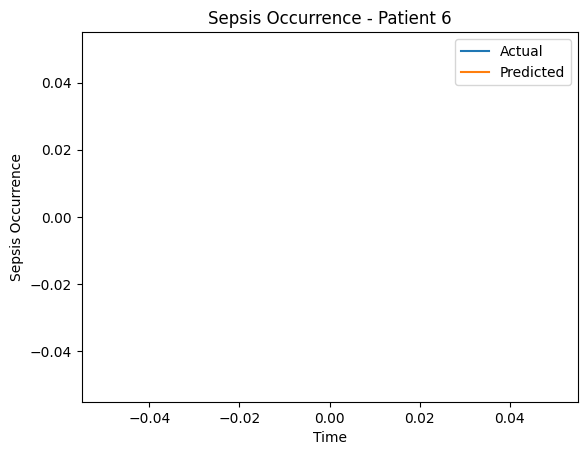

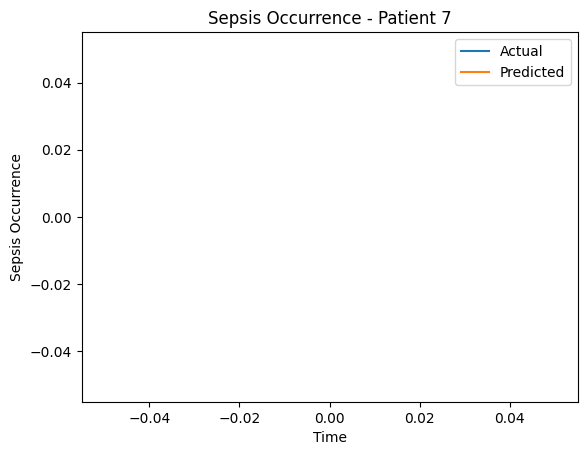

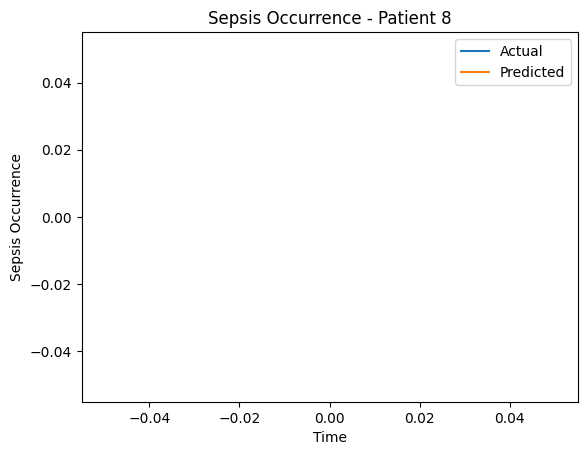

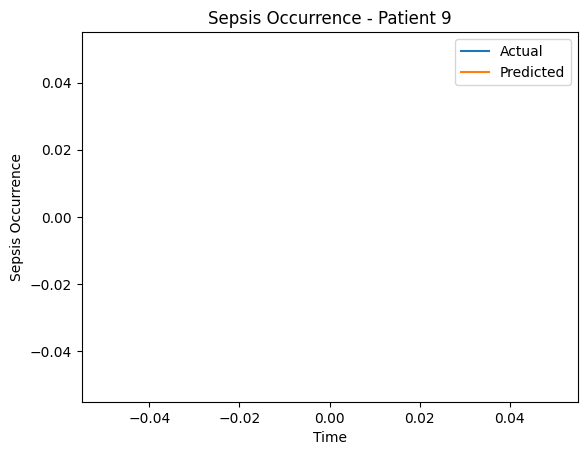

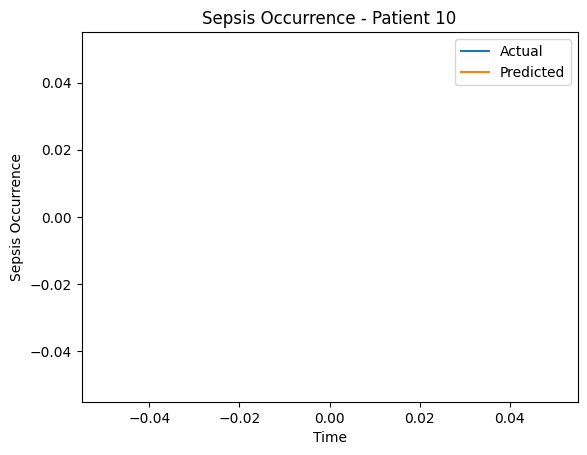

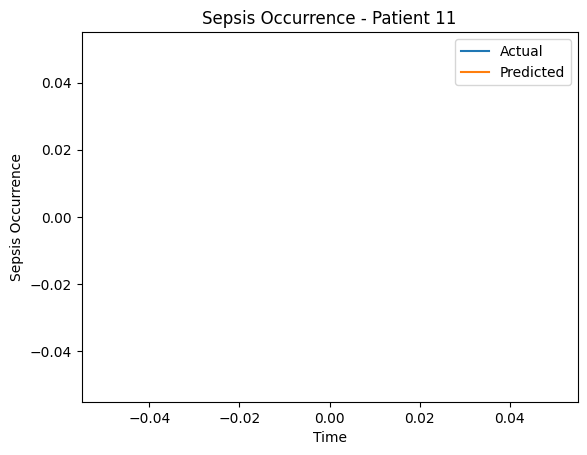

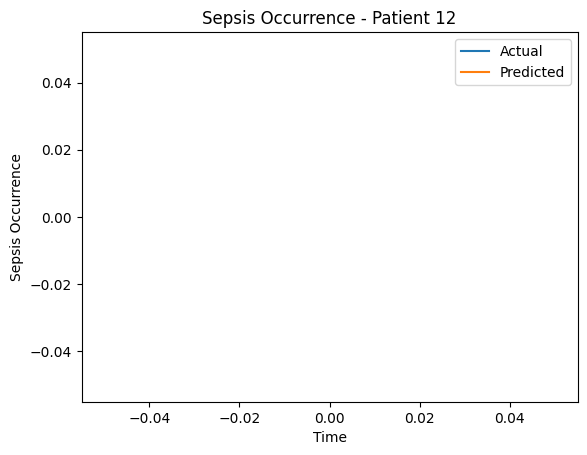

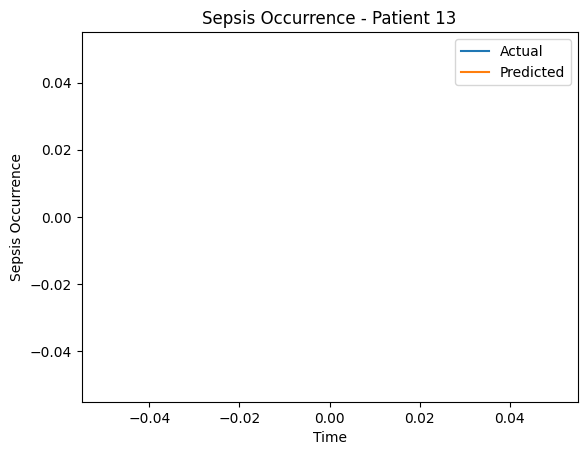

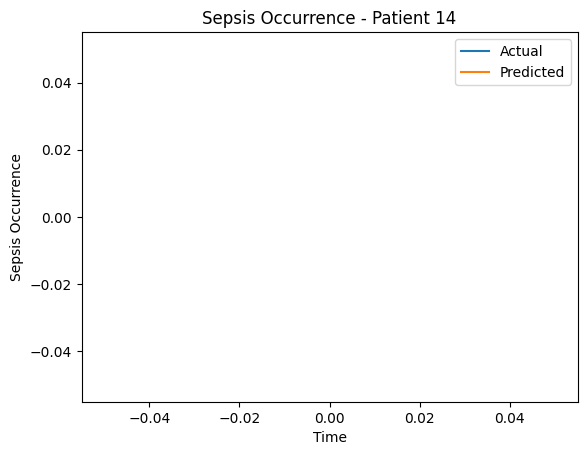

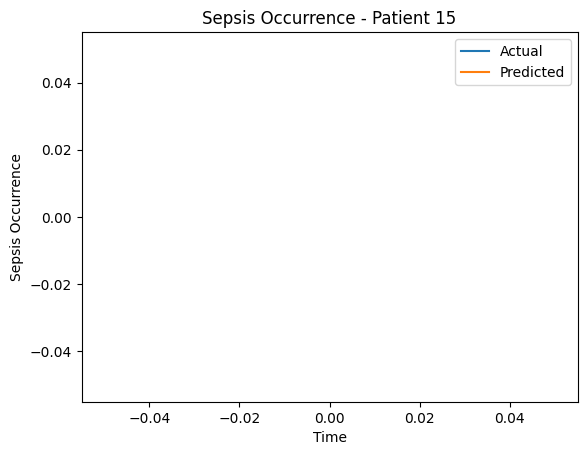

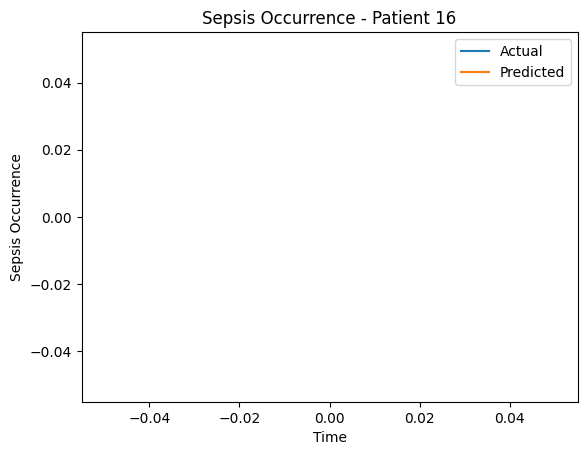

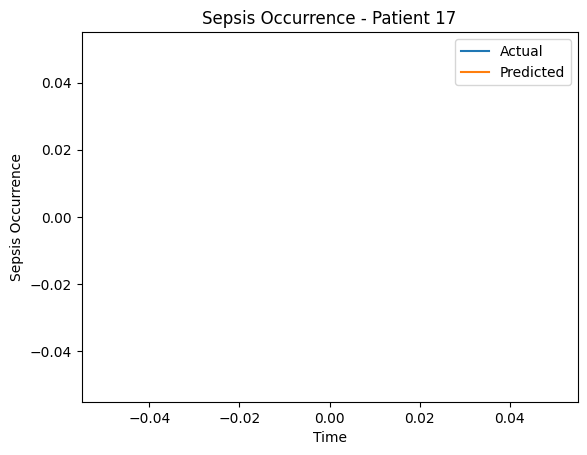

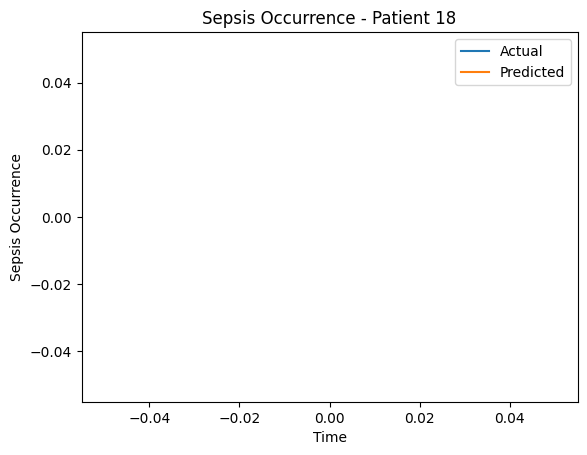

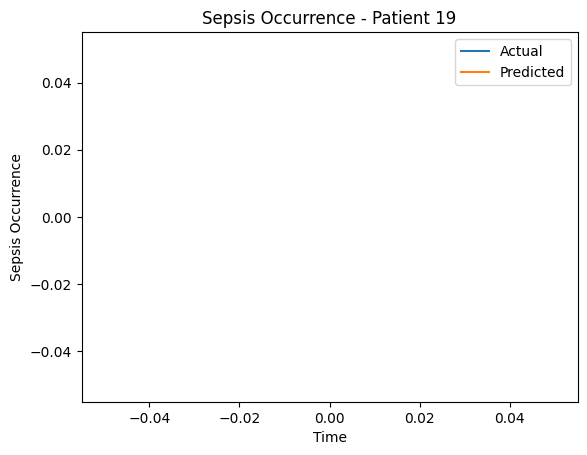

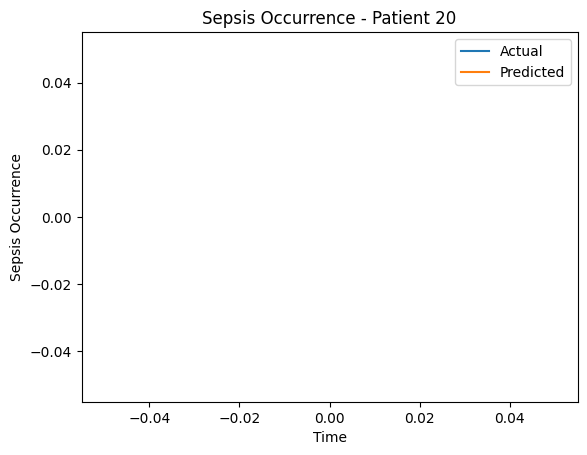

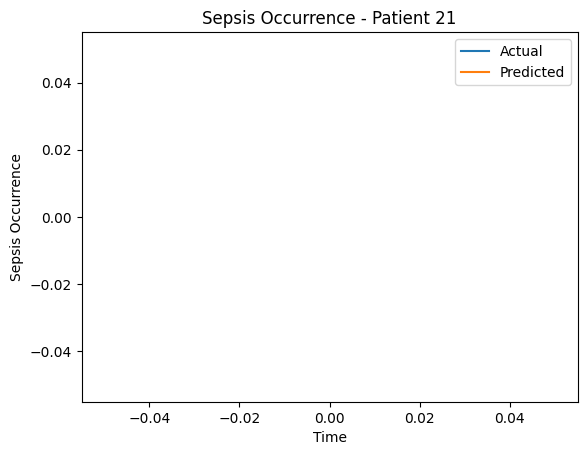

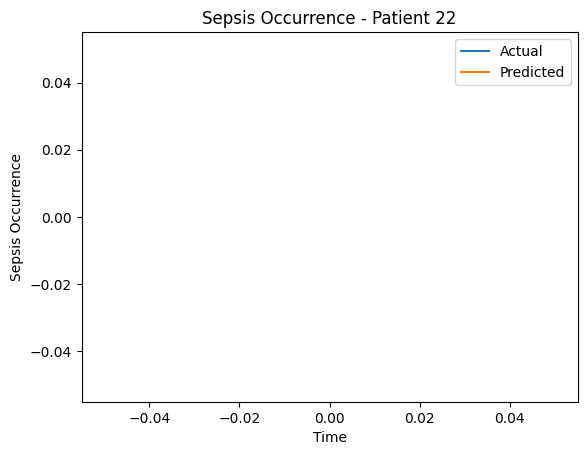

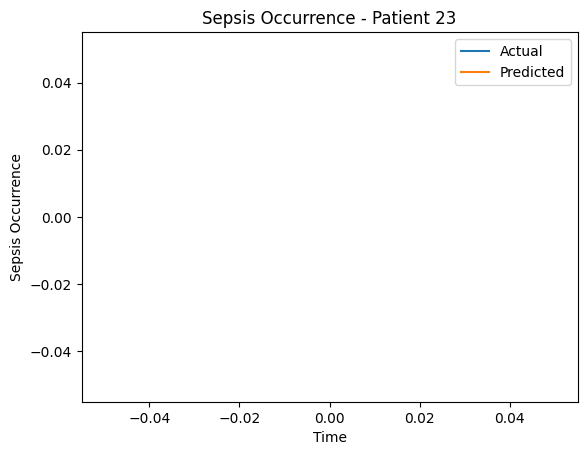

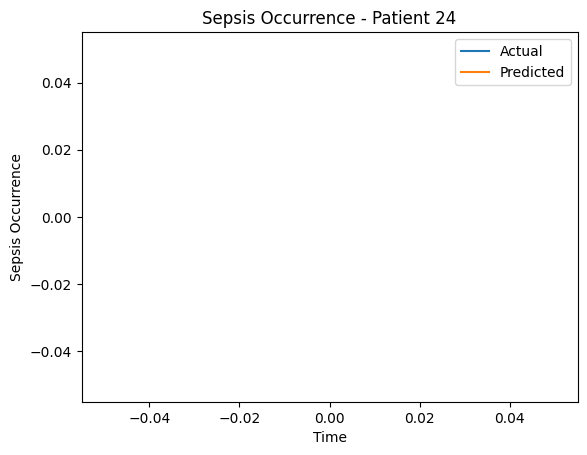

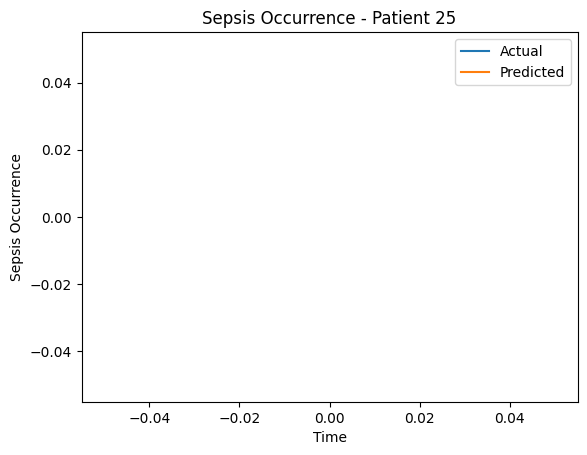

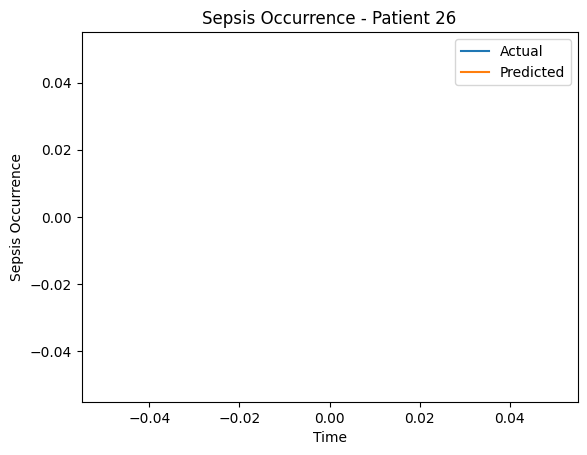

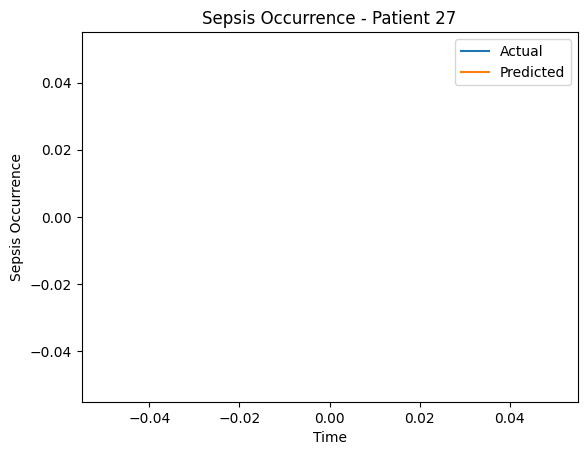

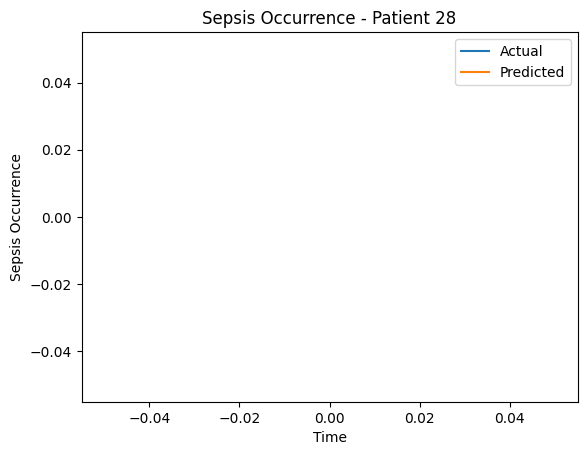

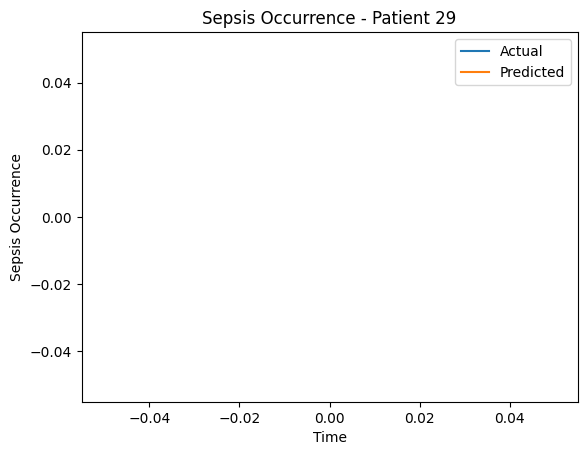

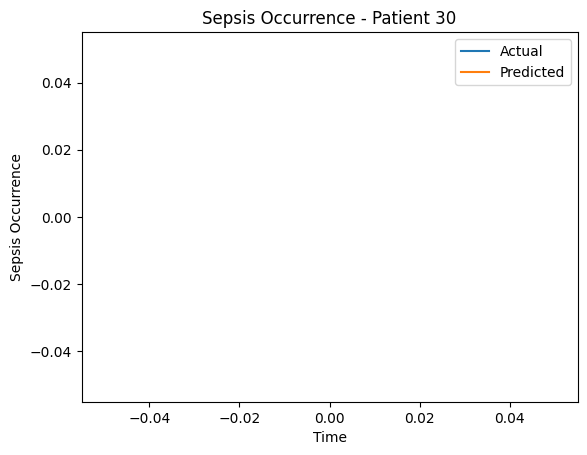

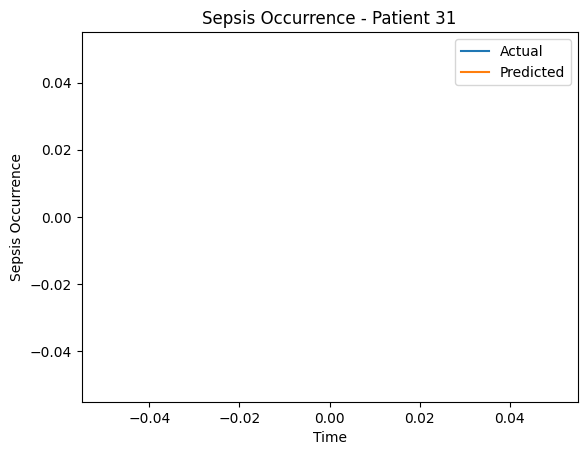

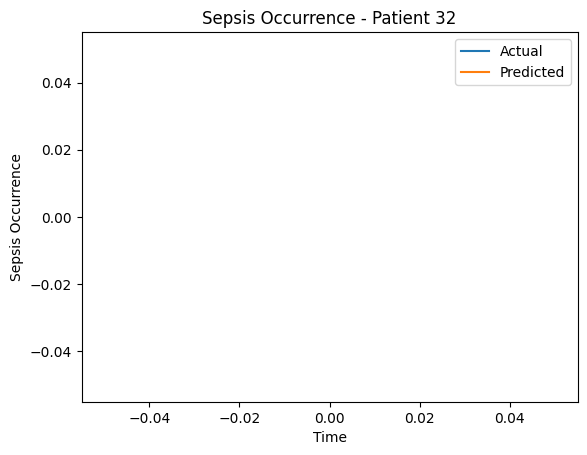

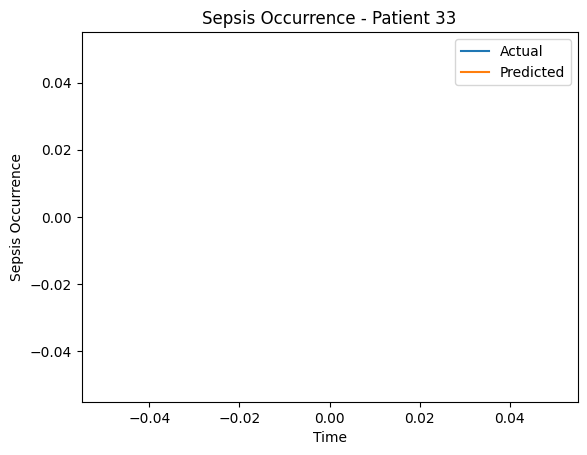

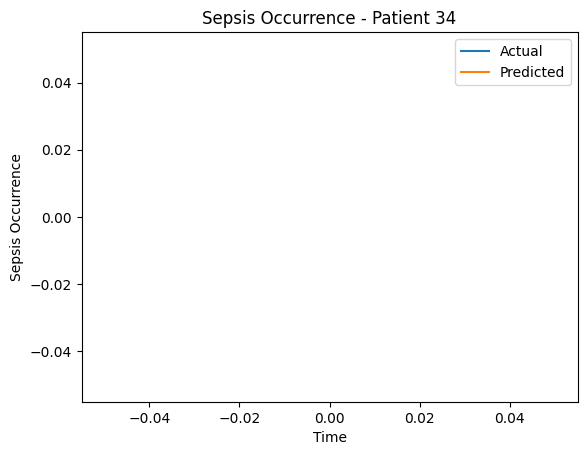

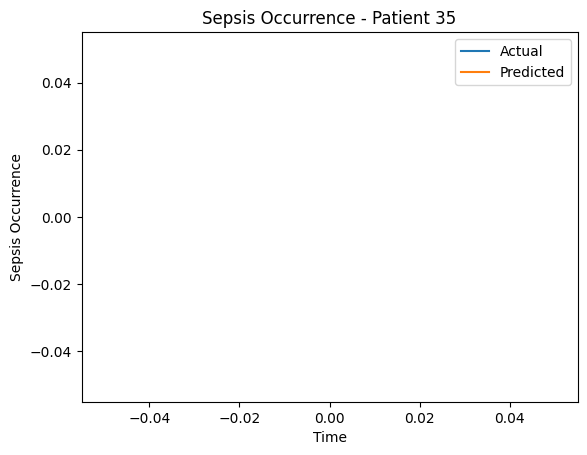

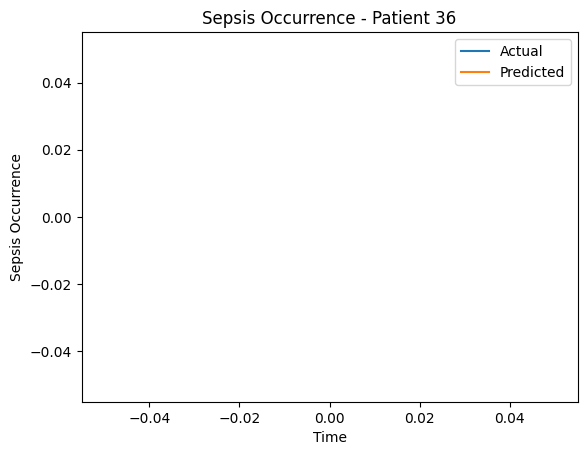

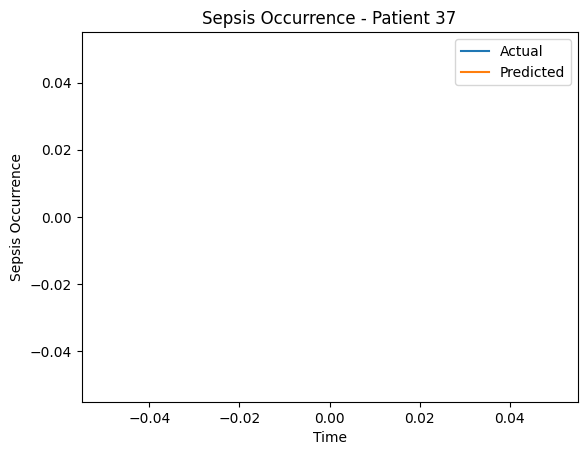

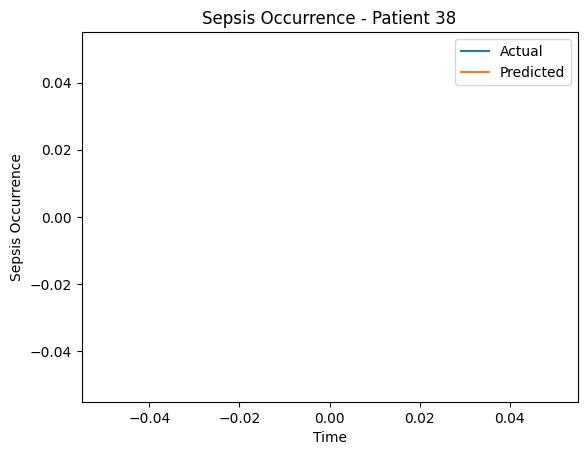

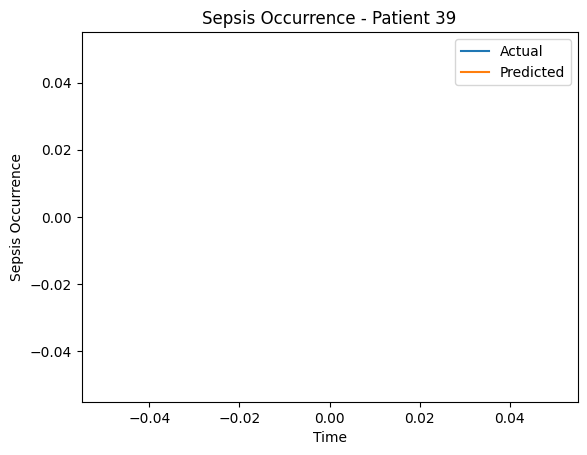

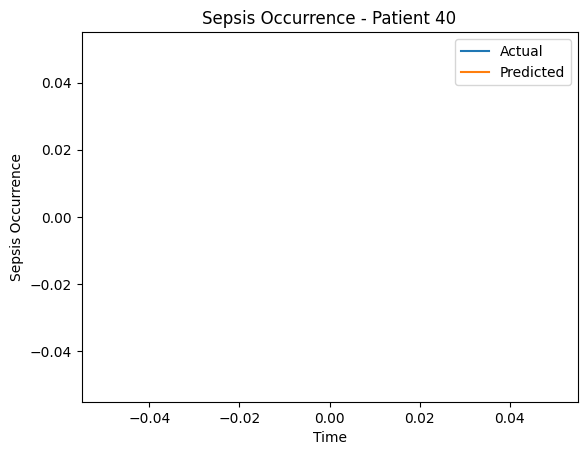

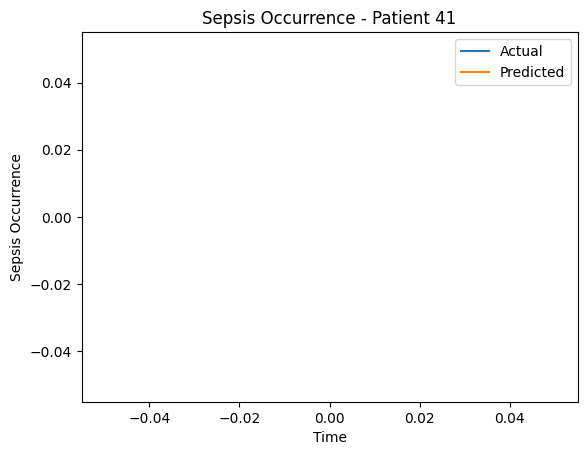

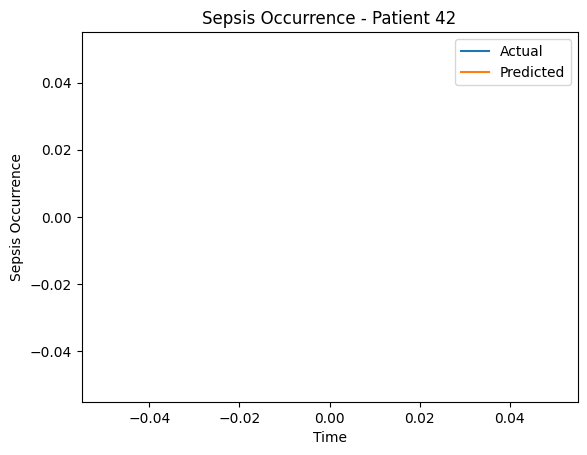

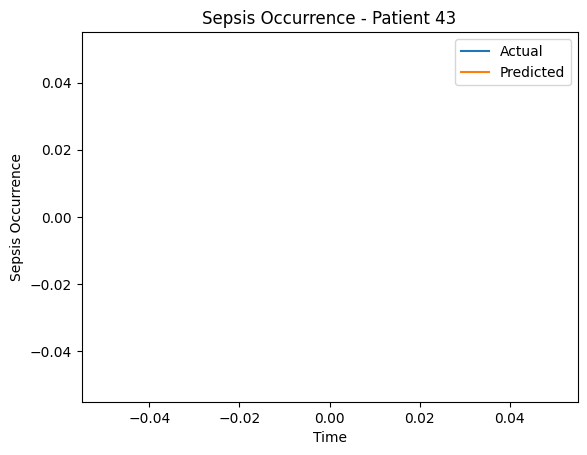

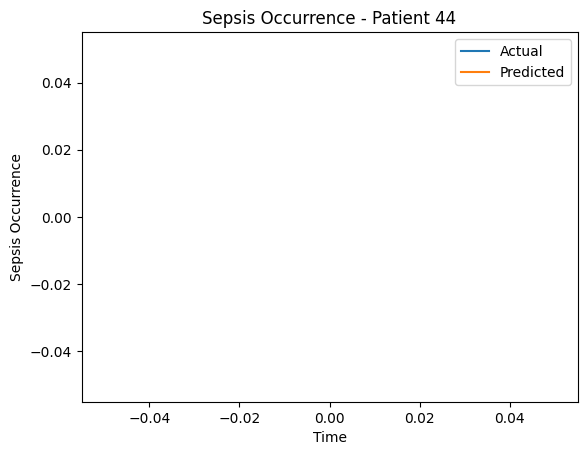

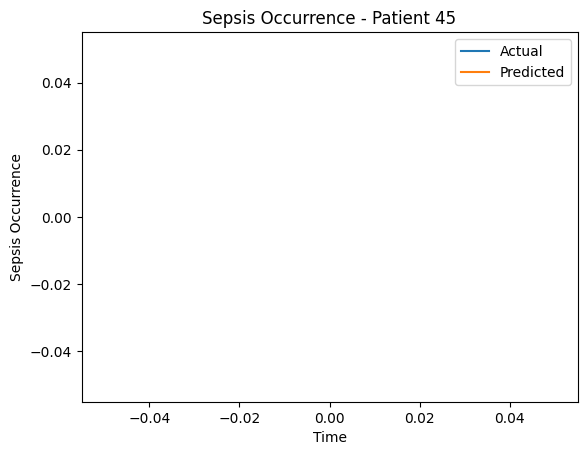

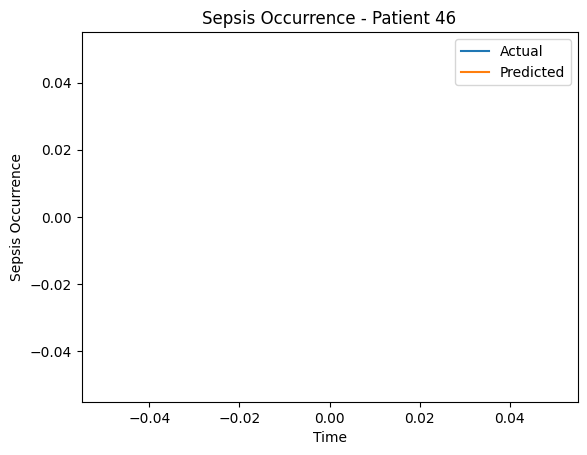

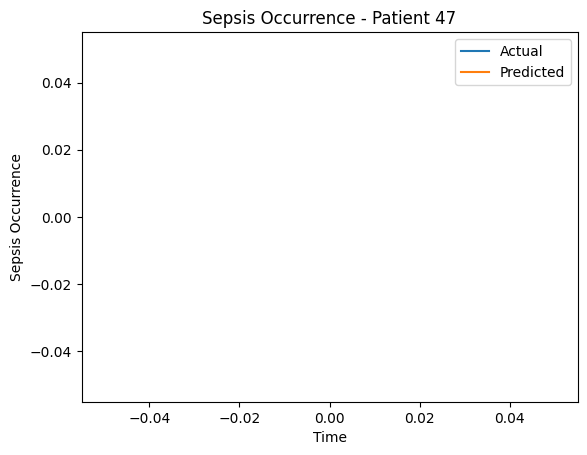

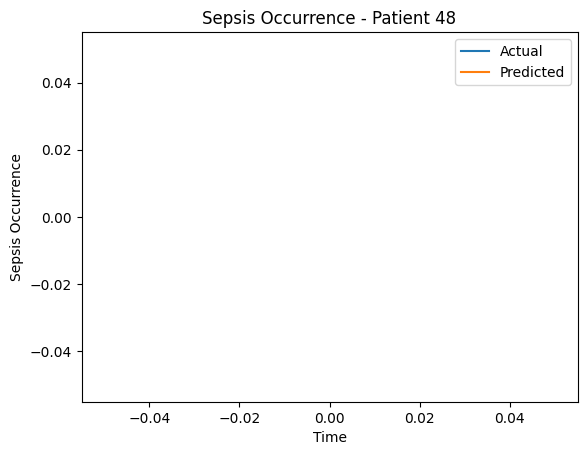

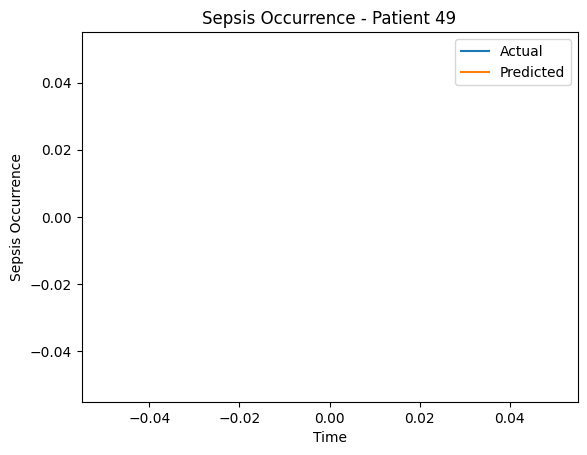

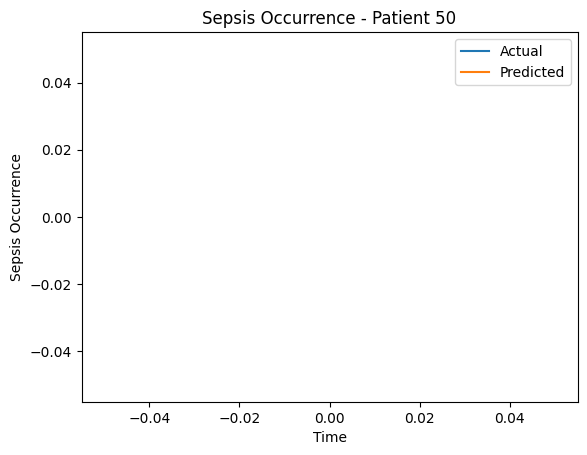

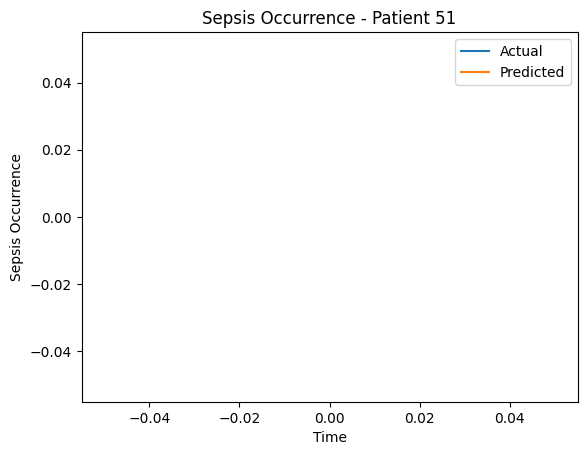

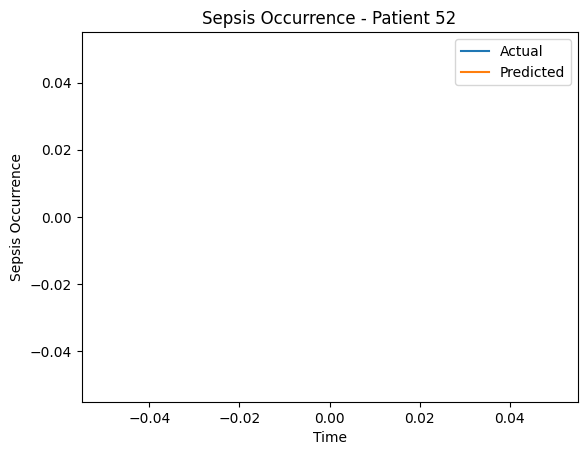

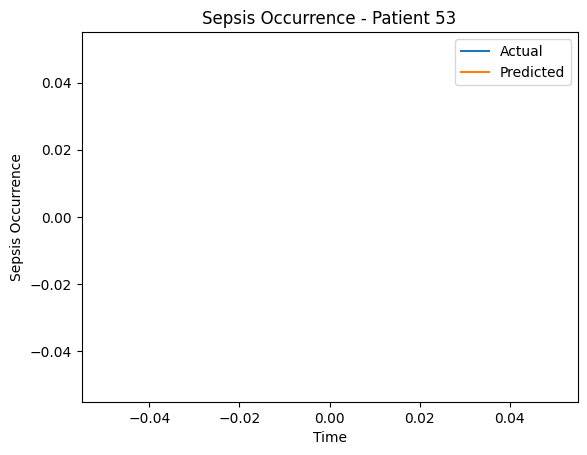

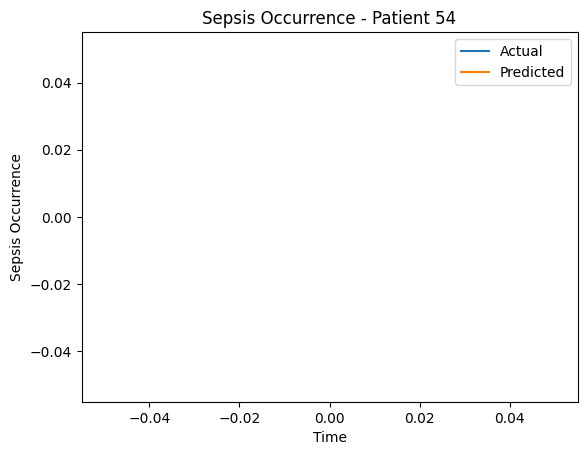

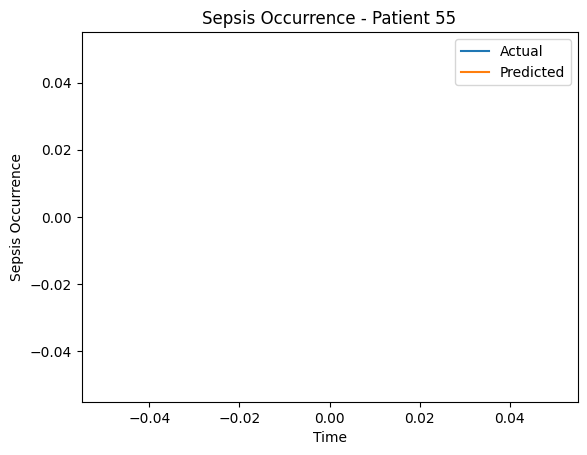

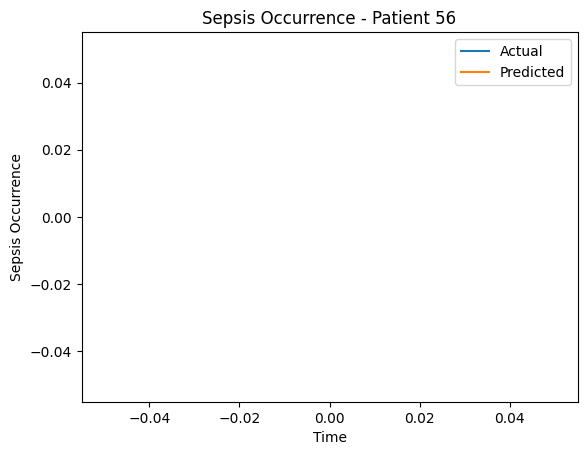

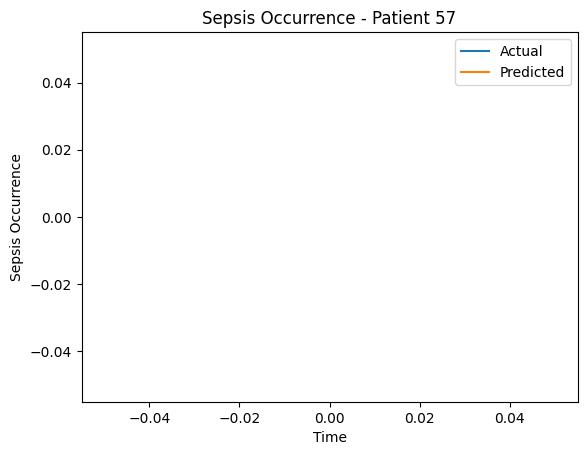

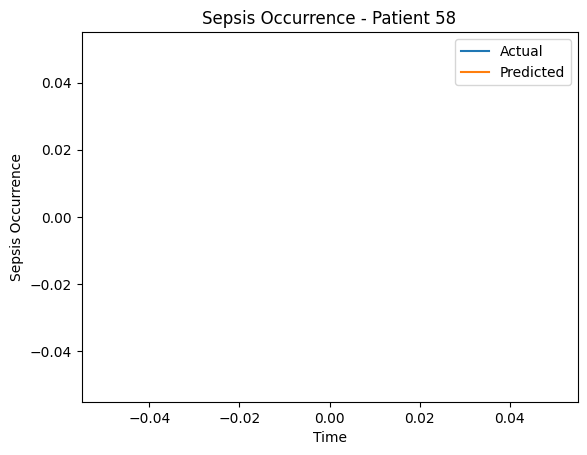

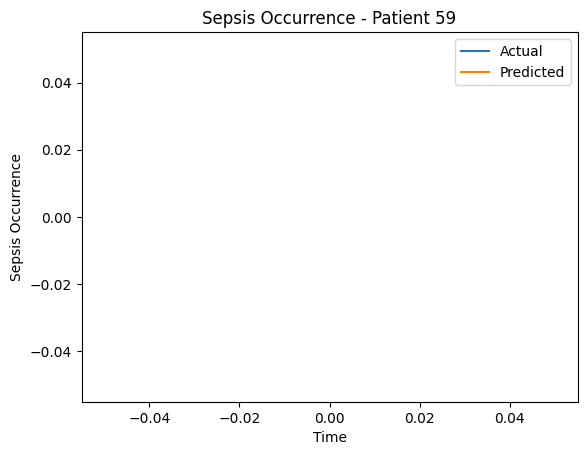

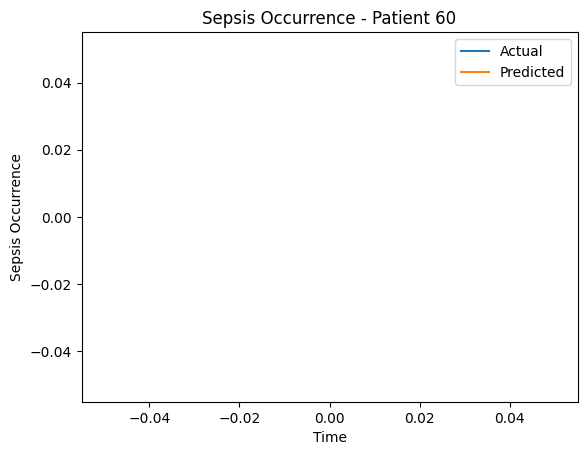

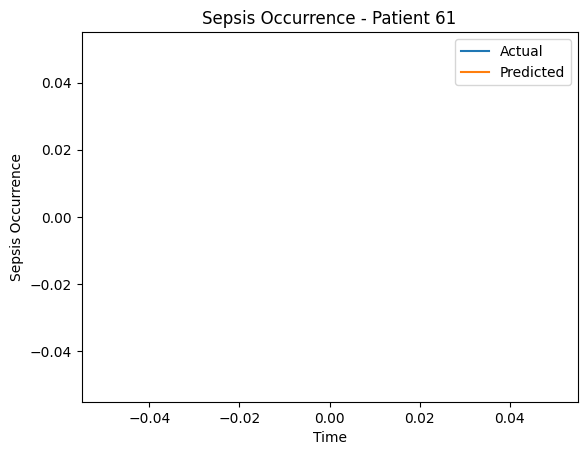

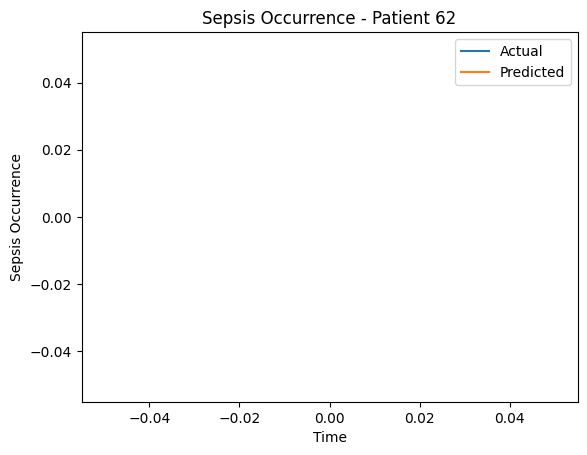

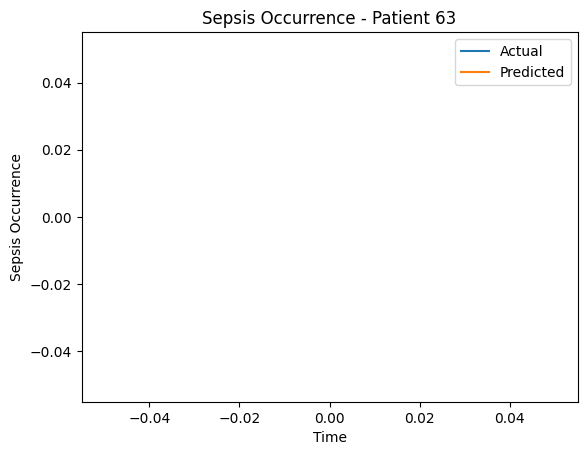

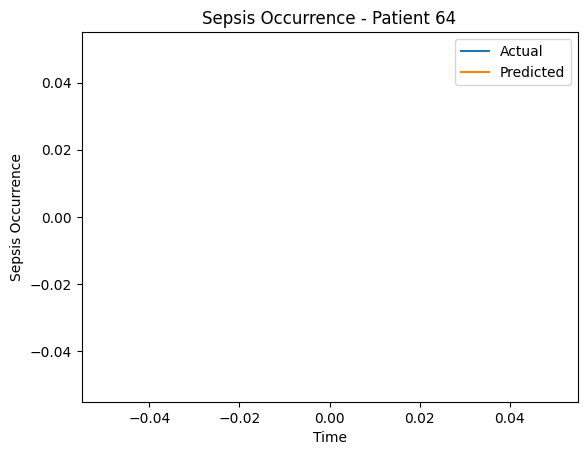

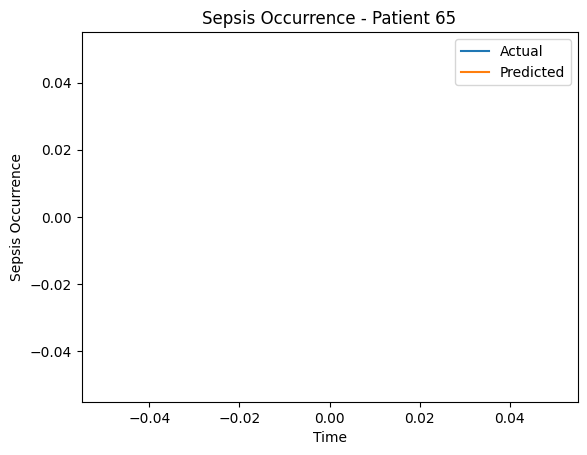

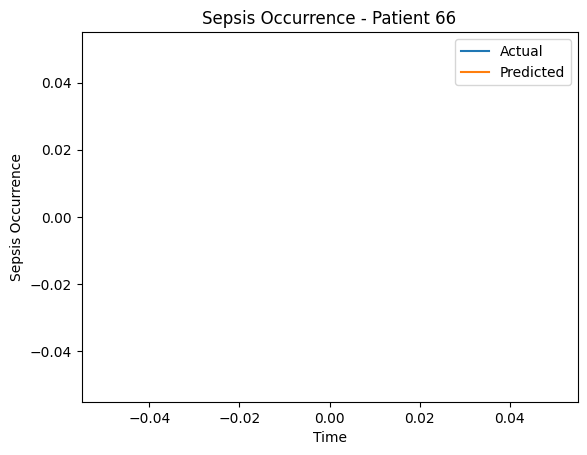

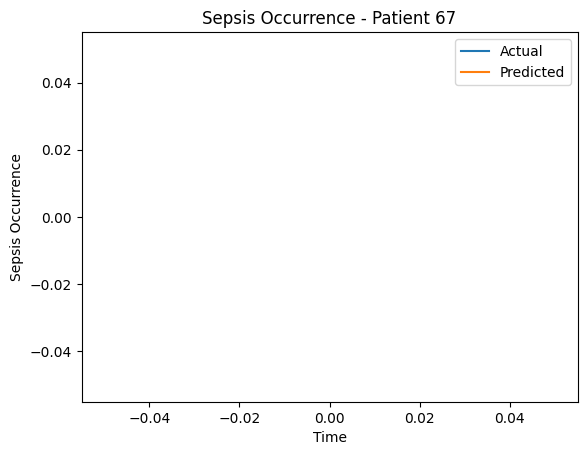

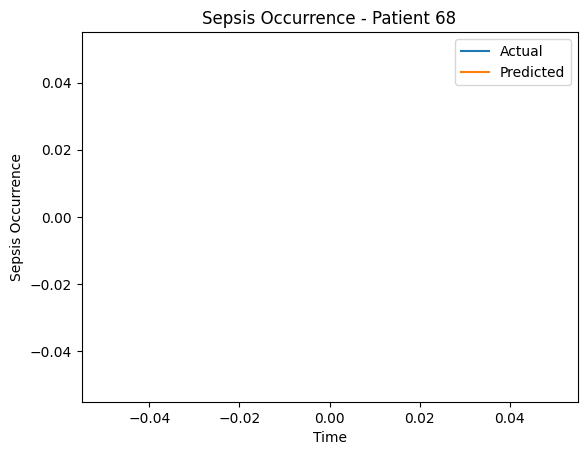

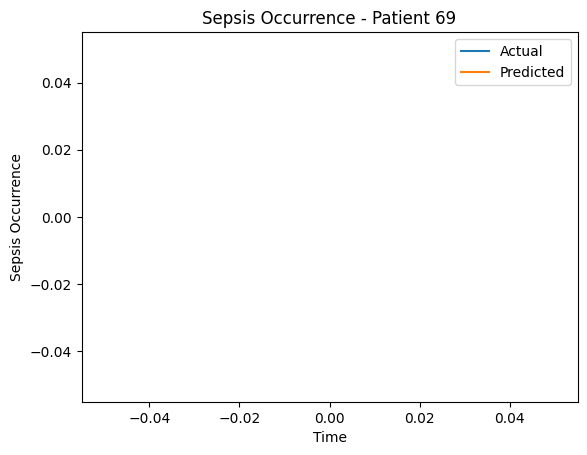

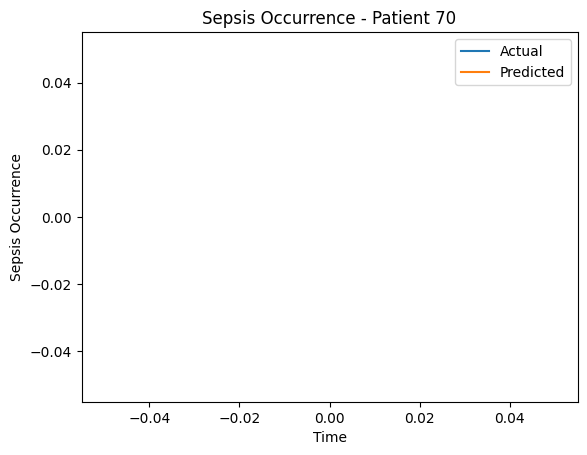

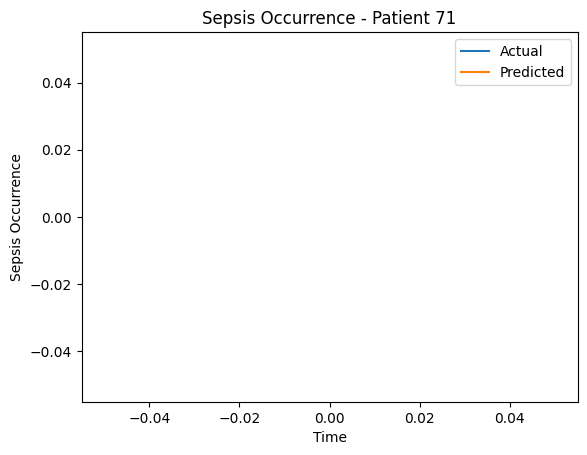

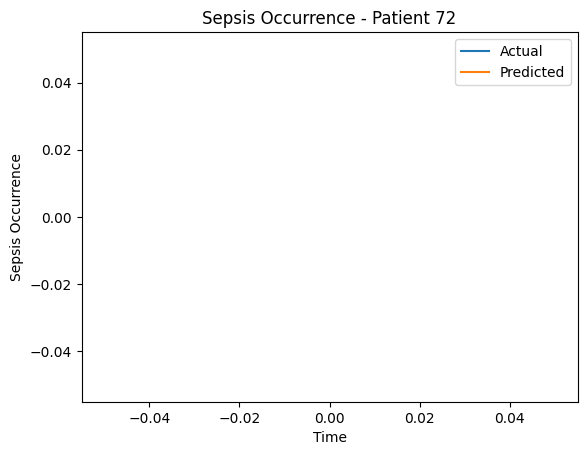

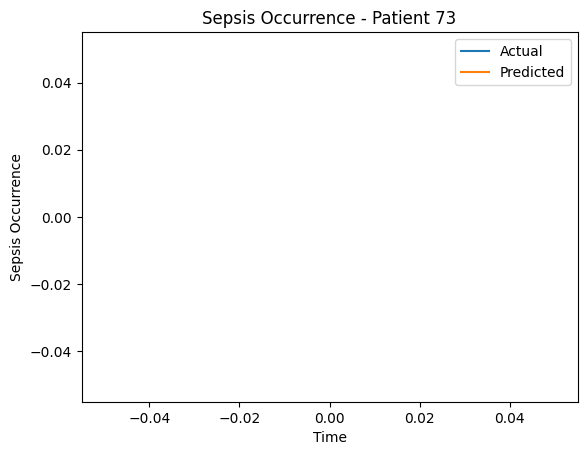

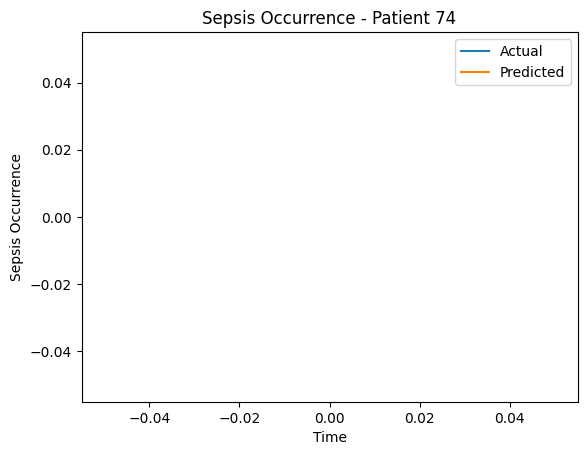

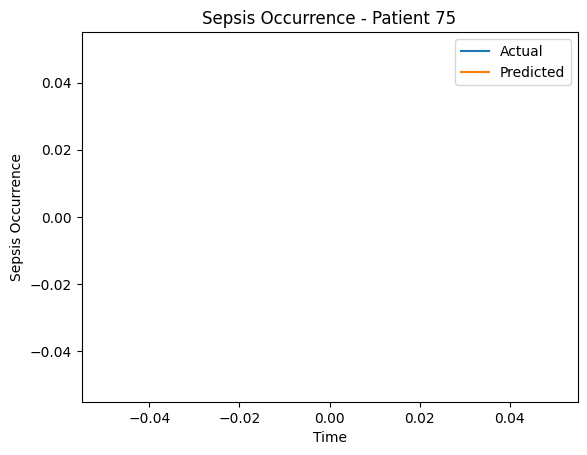

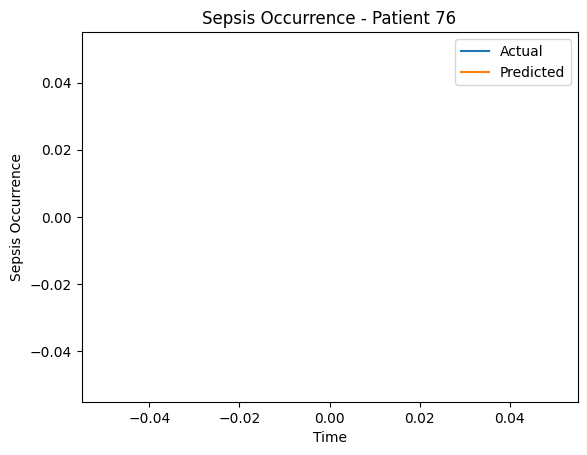

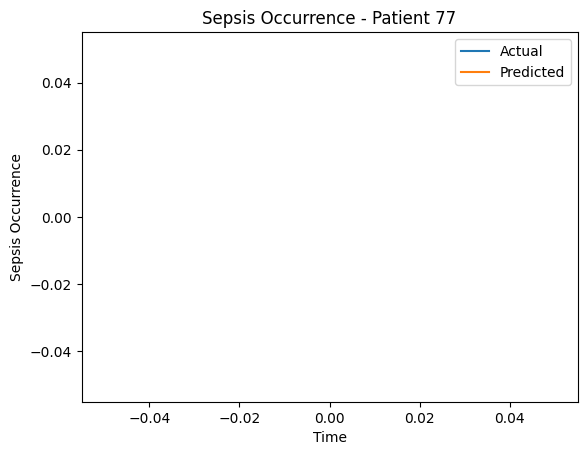

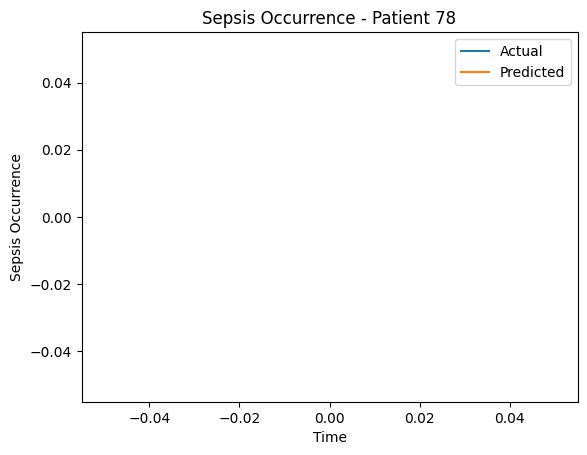

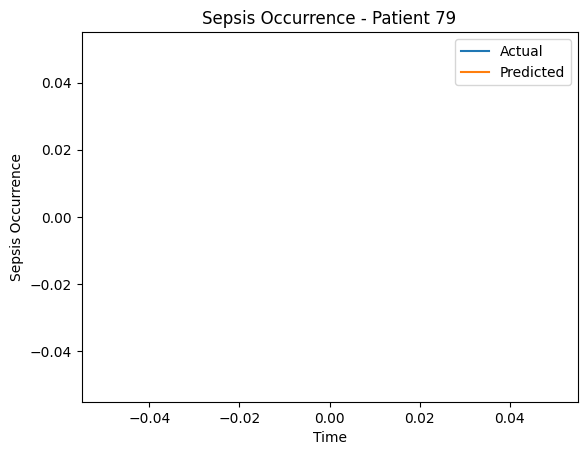

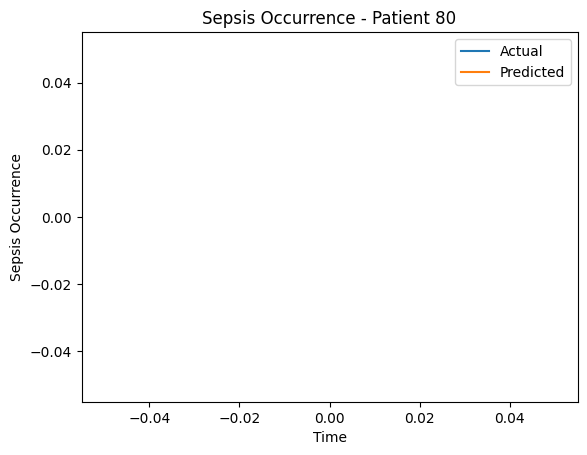

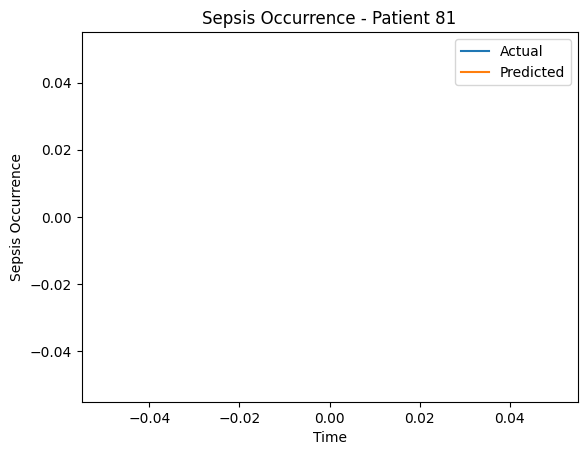

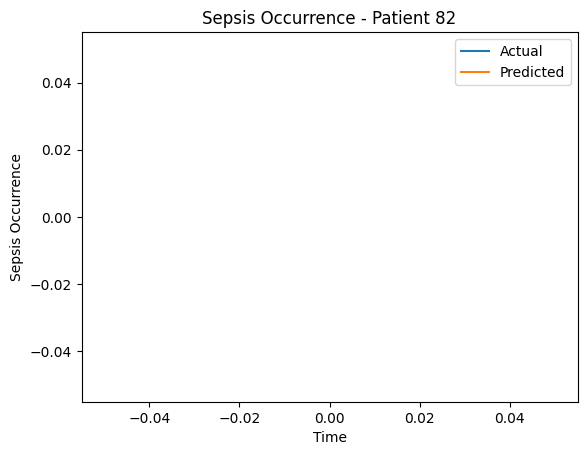

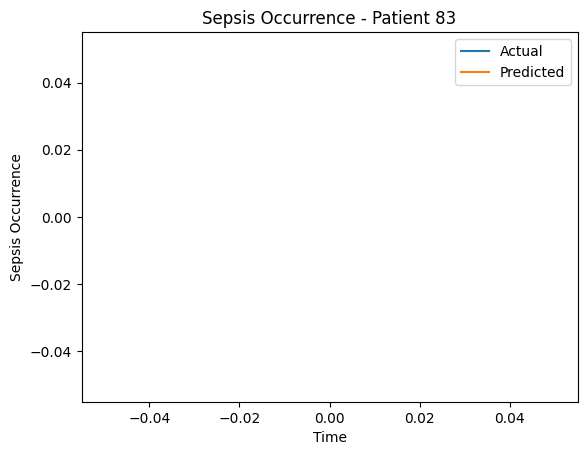

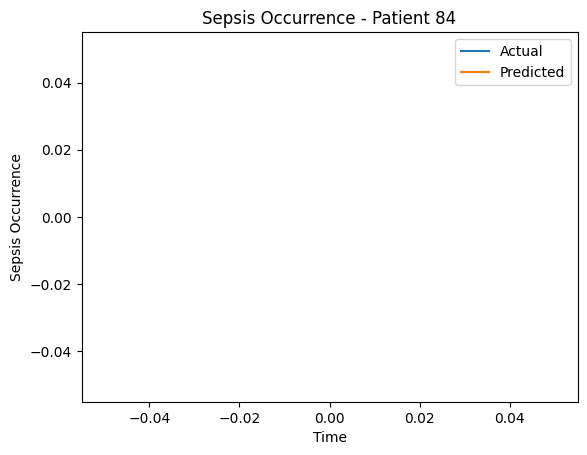

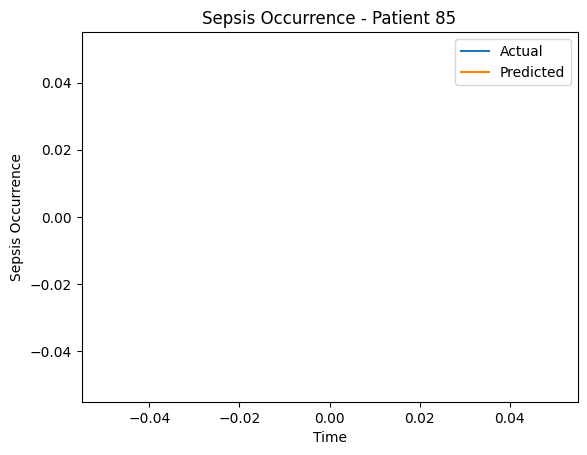

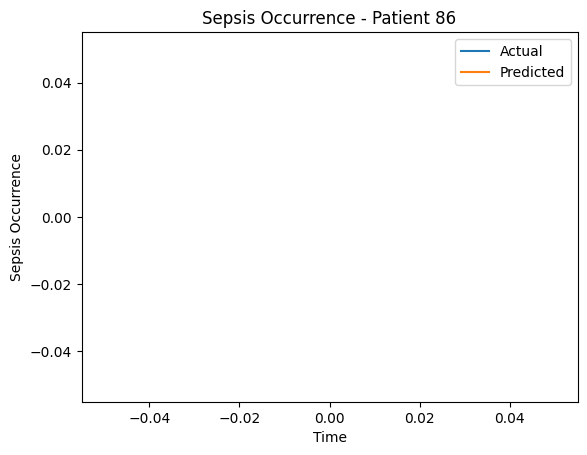

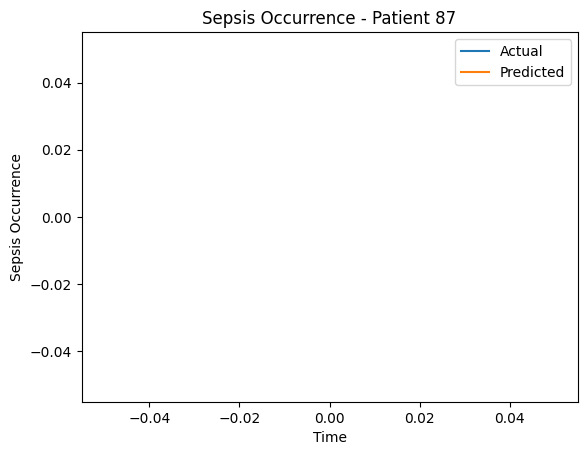

KeyboardInterrupt: ignored

In [182]:
import matplotlib.pyplot as plt

# Assuming you have the test_y_true (true labels) and test_y_pred (predicted labels) from your LSTM model

# Plot actual and predicted sepsis occurrences for each patient
plt.figure(figsize=(12, 6))
for i in range(len(test_y_true)):
    plt.plot(test_y_true[i], label='Actual')
    plt.plot(test_y_pred[i], label='Predicted')
    plt.title(f"Sepsis Occurrence - Patient {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Sepsis Occurrence")
    plt.legend()
    plt.show()

In [179]:
# np.concatenate((test_y_pred, test_y_true), axis=1)

ValueError: ignored

## Open Questions and To Dos



*   How to interpolate missing data?
*   How to deal with overly incomplete data/which cases should be excluded?
*   Predict into future (n-steps ahead)


